# Intoduction
* **Gray-wolf optimizer is a new evolutionary computation technique which mimics the leadership hierarchy and hunting mechanism of gray wolves in nature.**
* **The aim of the gray wolf optimization is find optimal regions of the complex search space through the interaction of individuals in the population.**
* **Compared to PSO(particle swarm optimization) and GA(Genetic Algo) this gives better results with UCI machine learning data repository e.g UCI Breast Cancer dataset.**
* **This proves better performance in both classification accuracy and feature size reduction.**
* **And GWO is much more robust than GA & PSO.**

**Just click here to instantly move to that place**<br>
* [Utils](#utils)
* [Data Preparation](#dataPreparation)
* [Gray Wolf Optimization](#GWO)
    - [Feature Extraction](#FE)
    - [Data Preparation](#DP)
    - [Classification](#classification)
* [Genetic Algorithm](#GA)
    - [Classification](#GC)
* [Particle Swarm Optimizatioin](#PSO)
    - [Classification](#PC)
* [Hybrid GWO JAYA](#HGJ)
    - [Classification](#HC)


# Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Installs

In [ ]:
# If these packages are not installed on your python env then install them by uncommenting them.

!pip install zoofs          # For GWO implementation
!pip install sklearn-genetic   # For GA implementation
!pip install niapy --pre
!pip install scikit-learn

  Preparing metadata (setup.py) ... done
  Created wheel for zoofs: filename=zoofs-0.1.26-py3-none-any.whl size=23600 sha256=eec4575b1871e2e819699d74b37d2099fefcfc8d7c9a9d15e325572f139dcce8
  Stored in directory: /root/.cache/pip/wheels/c5/47/90/d0547288297679ffb3e38d6d5b700dab7bc0314cf677051b77
Successfully built zoofs
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 33.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 49.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 346.6/346.6 kB 38.3 MB/s eta 0:00:00
  Attempting uninstall:

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.random import rand
import os
import random
from numpy import mean
from numpy import std
from sklearn.model_selection import KFold
from niapy.problems import Problem
from niapy.task import Task
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
from niapy.algorithms.basic import ParticleSwarmOptimization
from sklearn.svm import SVC
from sklearn import datasets, linear_model
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from genetic_selection import GeneticSelectionCV
sc = StandardScaler()

<a name='utils'></a>
# Utils

In [ ]:
# here X is features and y is labels
# k is the num_ of splits usally k = 3, k =5, or k = 10
def kfold(k, model, X, y):

  # prepare the cross-validation procedure
  cv = KFold(n_splits=k, random_state=1, shuffle=True)  # 10-fold cross-validation
  # evaluate model
  scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
  # report performance
  acc = mean(scores)

  return acc, scores.min(), scores.max()

def k_evaluate(k,model,x , y):
  acc_list = {}
  for i in range(2, k+1):
    acc,_,_ = kfold(i, model, x, y)
    acc_list.update( {i : acc} )
    print(f"for fold: {i}, accuracy is: {acc_list.get(i)}")
  # get max
  m_key = max(acc_list, key = acc_list.get)
  print("Best fit"             )
  print(f"{m_key} gives accuracy of {acc_list.get(m_key)}")
  return acc_list.get(m_key) # acc


# error rate
def error_rate(xtrain, ytrain, x, opts):
    # parameters
    k     = opts['k']
    fold  = opts['fold']
    xt    = fold['xt']
    yt    = fold['yt']
    xv    = fold['xv']
    yv    = fold['yv']

    # Number of instances
    num_train = np.size(xt, 0)
    num_valid = np.size(xv, 0)
    # Define selected features
    xtrain  = xt[:, x == 1]
    ytrain  = yt.reshape(num_train)  # Solve bug
    xvalid  = xv[:, x == 1]
    yvalid  = yv.reshape(num_valid)  # Solve bug
    # Training
    mdl     = KNeighborsClassifier(n_neighbors = k)
    mdl.fit(xtrain, ytrain)
    # Prediction
    ypred   = mdl.predict(xvalid)
    acc     = np.sum(yvalid == ypred) / num_valid
    error   = 1 - acc

    return error


# Error rate & Feature size
def Fun(xtrain, ytrain, x, opts):
    # Parameters
    alpha    = 0.99
    beta     = 1 - alpha
    # Original feature size
    max_feat = len(x)
    # Number of selected features
    num_feat = np.sum(x == 1)
    # Solve if no feature selected
    if num_feat == 0:
        cost  = 1
    else:
        # Get error rate
        error = error_rate(xtrain, ytrain, x, opts)
        # Objective function
        cost  = alpha * error + beta * (num_feat / max_feat)

    return cost

def evaluate_fn(Y_test,model_pred):
    # cm = confusion_matrix(Y_test.argmax(), model_pred.argmax())
    cm = confusion_matrix(Y_test.astype(int).tolist(), model_pred)

    True_Positives = cm[0][0]
    False_Positives = cm[0][1]

    True_Negetives = cm[1][1]
    False_Negetives = cm[1][0]

    # return True_Positives,False_Positives,False_Negetives,True_Negetives

    precision =  True_Positives / (True_Positives + False_Positives)
    recall = True_Positives / (True_Positives + False_Negetives)
    f1_score = 2*(precision * recall) / (precision + recall)

    return precision,recall,f1_score

<a name='dataPreparation'></a>
# Data Preparation

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Work Space/cns.csv")
data.head()

samples        V1        V2        V3        V4        V5        V6  \
0        1 -0.927178 -0.740039 -0.532016 -1.097891 -0.986673  0.018752   
1        2 -0.835899 -0.835899 -0.585647 -0.835899 -0.329768 -0.835899   
2        3  0.236073  0.252645 -1.154351 -0.372372 -0.338900  1.253467   
3        4 -0.748623 -0.439165  0.790953 -1.033876  0.241115  1.216007   
4        5  0.101239 -0.298285 -1.121519 -0.957714  0.342258  1.182937   

         V7        V8        V9  ...     V6025     V6026     V6027     V6028  \
0 -0.863326  3.959997 -0.398219  ... -1.097891 -1.097891 -0.894733  0.850270   
1 -0.835899  4.037788 -0.835899  ... -0.835899 -0.835899 -0.835899  0.038090   
2  0.506325  3.868961  0.201932  ... -1.154351 -1.154351 -0.372372  0.899781   
3  0.106282  3.976272  0.081755  ... -1.121534 -1.121534 -0.812076  1.230378   
4  0.029325  4.575871 -0.196466  ... -1.121519 -1.121519 -0.454932  0.891627   

      V6029     V6030     V6031     V6032     V6033  response  
0 -1.097891 -0.302063 -0.767685 -0.452616  0.194001    normal  
1 -0.835899 -0.835899 -0.835899 -0.835899  0.075500    normal  
2 -0.867200  0.360426 -1.154351 -1.154351 -1.154351    normal  
3 -0.355497  0.030647 -0.278810 -1.121534 -1.121534    normal  
4 -0.593427  0.306316 -0.076496 -0.134480 -1.121519    normal  

[5 rows x 6035 columns]

In [ ]:
# t = data.loc[0:10,"samples":"V10"]
# Drop column samples
data.drop(["samples"], axis = 1, inplace=True)
# Now shuffle it
data = data.sample(frac = 1)

In [ ]:
# Take a slice from dataset
# data.loc[0:5,"V6025":"response"]

In [ ]:
data["response"].unique()

array(['normal', 'tumer'], dtype=object)

We have 2 types of classes one is 'normal' and another is 'tumer'.

In [ ]:
print("Lenght of Dataset:", len(data))
print("Num of columns:", len(data.columns))

Lenght of Dataset: 102
Num of columns: 6034


## Plots

<Axes: xlabel='response', ylabel='count'>

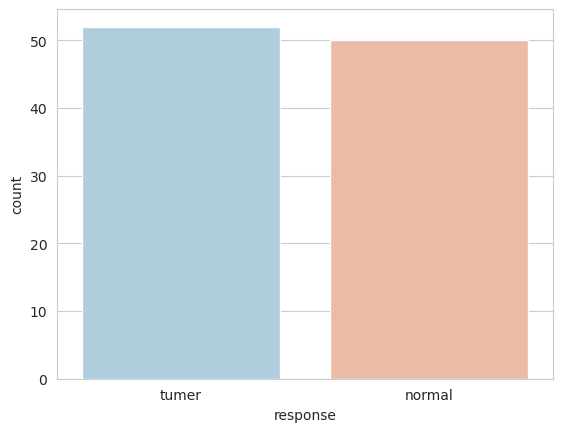

In [ ]:
sns.set_style('whitegrid')
sns.countplot(x = 'response', data= data,palette = 'RdBu_r')

We can see the dataset is balanced here. Which is a very good thing.

##Extra data preparation

In [ ]:
# class values are in byte string format but we need them in integer format
# Converting them into string first
y = data.response  # label
# len(y)
# y[0]
def cvt(str):
  return str.decode("utf-8")

for st in range(len(y)):
  y[st] = y[st]
# print(y)

<ipython-input-8-afc1346df41b>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[st] = y[st]
<ipython-input-8-afc1346df41b>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[st] = y[st]
<ipython-input-8-afc1346df41b>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[st] = y[st]
<ipython-input-8-afc1346df41b>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the docu

In [ ]:
# Then convert them into integer
y.replace({"normal": 0, "tumer": 1}, inplace= True)
# convert label type to float
y = y.astype(float)

In [ ]:
# grab our features
x = data.drop(['response'], axis=1)
# Fetch list of columns
cols = (data.columns).to_list()
len(cols)

6034

In [ ]:
# convert numpy array to dictionary
col_dict = dict(enumerate((x.columns.to_numpy()).flatten(), 0))
len(col_dict)

6033

## Train Test Split

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 101)
print("x_train shape: ", x_train.shape)
print("y_train shape: ", y_train.shape)
print("x_text: ",x_test.shape)
print("y_test: ",y_test.shape)

x_train shape:  (81, 6033)
y_train shape:  (81,)
x_text:  (21, 6033)
y_test:  (21,)


In [ ]:
# sc = StandardScaler()
# x_train = sc.fit_transform(x_train)
# x_test = sc.transform(x_test)

In [ ]:
# type(x_train)  # make sure x_train should be in pandas.core.frame.DataFrame format

# GWO(Grey Wolf Optimization)

## Extracting Features

In [ ]:
from zoofs import GreyWolfOptimization

In [ ]:
# Set up objective function
from sklearn.metrics import log_loss
# make sure that objective fun shoud recieve 4 parameters
# Now fit your model to return objective vaule
def objective_function(model,X_train, y_train, X_valid, y_valid):
    model.fit(X_train,y_train)
    P=log_loss(y_valid,model.predict_proba(X_valid))
    return P


In [ ]:
# create object of algorithm
# population_size=? change this number if you want more features depending open your computation power
algo_object=GreyWolfOptimization(objective_function,n_iteration=20,
                                    population_size=100,minimize=True)

In further code x_train type will may be differ but here it need x_train to be of type pandas.core.frame.DataFrame, so make sure x_train type be the same.

In [ ]:
# Import and initialize classifier
# import lightgbm as lgb
lgb_model = LinearDiscriminantAnalysis()

# Fit the classifier
features = algo_object.fit(lgb_model,x_train, y_train, x_train, y_train,verbose=True)

 [ 2024-01-07 02:58:05,724 ] Finished iteration #0 with objective value 0.3001089986243915. Current best value is 0.3001089986243915 
 [ 2024-01-07 02:58:43,513 ] Finished iteration #1 with objective value 0.3107058060942826. Current best value is 0.3001089986243915 
 [ 2024-01-07 02:59:20,009 ] Finished iteration #2 with objective value 0.31279698419636837. Current best value is 0.3001089986243915 
 [ 2024-01-07 02:59:56,861 ] Finished iteration #3 with objective value 0.3115788821693611. Current best value is 0.3001089986243915 
 [ 2024-01-07 03:00:34,393 ] Finished iteration #4 with objective value 0.31134237844084783. Current best value is 0.3001089986243915 
 [ 2024-01-07 03:01:10,099 ] Finished iteration #5 with objective value 0.30830303509111406. Current best value is 0.3001089986243915 
 [ 2024-01-07 03:01:46,699 ] Finished iteration #6 with objective value 0.3135548102379899. Current best value is 0.3001089986243915 
 [ 2024-01-07 03:02:22,663 ] Finished iteration #7 with obj

In [ ]:
len(features)

4500

<a name=DP></a>
## Data Preparation

In [ ]:
# Fetching our new dataset with selected features
new_data = data[features]
new_data.head()

V1        V2        V4        V5        V6        V7        V8  \
34 -0.928031 -0.748737 -0.928031 -0.350003 -0.928031 -0.928031  4.713304   
96 -0.796615 -0.796615 -0.796615 -0.796615 -0.796615 -0.796615  4.480831   
74 -0.886589 -0.886589 -0.886589 -0.886589 -0.886589 -0.886589  4.390728   
18  0.262270  0.398709 -1.052937  0.931825  0.647813 -0.036681  3.772954   
80 -0.306310 -1.177570 -1.090664  0.130977 -0.061700 -0.592311  4.482299   

          V9       V10       V11  ...     V6018     V6022     V6024     V6026  \
34 -0.465831 -0.928031  0.246070  ... -0.748737 -0.748737 -0.350003 -0.928031   
96 -0.796615 -0.796615  0.566557  ... -0.126957 -0.796615 -0.796615 -0.796615   
74 -0.886589 -0.886589  0.968513  ... -0.215795 -0.886589 -0.794352 -0.886589   
18 -0.036681 -1.206832 -0.125614  ... -1.206832  0.971092  1.189593  0.232121   
80 -0.342073 -1.177570 -0.175827  ... -0.693730 -0.379295  0.805425 -1.177570   

       V6027     V6028     V6029     V6030     V6031     V6032  
34 -0.928031  0.331637 -0.928031 -0.928031 -0.928031 -0.928031  
96 -0.796615  0.049186  0.162978 -0.796615 -0.796615 -0.796615  
74 -0.886589  0.297720 -0.886589 -0.886589 -0.886589 -0.886589  
18 -1.206832  1.321822 -0.665052 -0.985374 -0.810109  1.199408  
80 -1.177570  1.072907 -0.501053  0.409432 -0.938340 -1.177570  

[5 rows x 4500 columns]

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(new_data, y, test_size = 0.2, random_state = 101)
print("x_train shape: ", x_train.shape)
print("y_train shape: ", y_train.shape)

x_train shape:  (81, 4500)
y_train shape:  (81,)


In [ ]:
# Data scalling
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

<a name=classification></a>
## Model

### SVC

In [ ]:
from sklearn.svm import SVC
model_SVC= SVC()
model_SVC.fit(x_train,y_train)
model_pred = model_SVC.predict(x_test)

from sklearn.metrics import classification_report, confusion_matrix
cm = confusion_matrix(y_test,model_pred)
print(cm)
print('\n')
print(classification_report(y_test,model_pred))

[[8 1]
 [3 9]]


              precision    recall  f1-score   support

           0       0.73      0.89      0.80         9
           1       0.90      0.75      0.82        12

    accuracy                           0.81        21
   macro avg       0.81      0.82      0.81        21
weighted avg       0.83      0.81      0.81        21



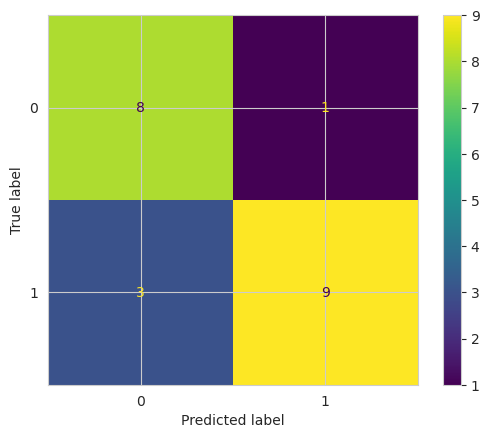

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_SVC.classes_)
disp.plot()

In [ ]:
# k fold cross validation
acc = k_evaluate(10, model_SVC, new_data, y)

for fold: 2, accuracy is: 0.6764705882352942
for fold: 3, accuracy is: 0.7941176470588235
for fold: 4, accuracy is: 0.8426923076923076
for fold: 5, accuracy is: 0.8528571428571429
for fold: 6, accuracy is: 0.8725490196078431
for fold: 7, accuracy is: 0.873469387755102
for fold: 8, accuracy is: 0.8822115384615385
for fold: 9, accuracy is: 0.882996632996633
for fold: 10, accuracy is: 0.901818181818182
Best fit
10 gives accuracy of 0.901818181818182


### Naive Bayes

[[6 3]
 [5 7]]


              precision    recall  f1-score   support

           0       0.55      0.67      0.60         9
           1       0.70      0.58      0.64        12

    accuracy                           0.62        21
   macro avg       0.62      0.62      0.62        21
weighted avg       0.63      0.62      0.62        21



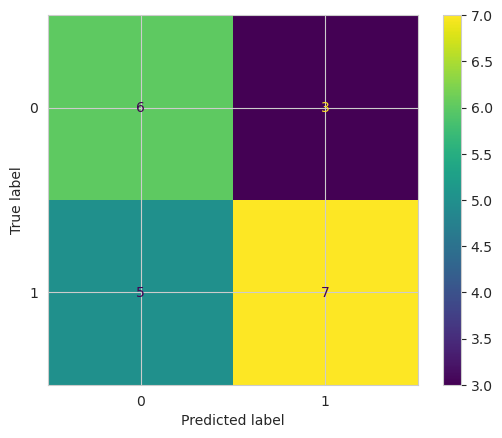

In [ ]:
gnb = GaussianNB()
gnb.fit(x_train, y_train)

y_pred = gnb.predict(x_test)
cm = confusion_matrix(y_test,y_pred)
print(cm)
print('\n')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=gnb.classes_)
disp.plot()
print(classification_report(y_test,y_pred))

In [ ]:
# Calculate all
precision,recall,f1_score = evaluate_fn(y_test, y_pred)  # takes y_test and model pred
print("precision : ",precision,'\n',"recall :",recall,'\n',"f1_score :",f1_score)

# K-Fold
acc = k_evaluate(10, gnb, new_x, y)

precision :  0.6666666666666666 
 recall : 0.5454545454545454 
 f1_score : 0.6
for fold: 2, accuracy is: 0.5784313725490196
for fold: 3, accuracy is: 0.5882352941176471
for fold: 4, accuracy is: 0.5884615384615385
for fold: 5, accuracy is: 0.6190476190476191
for fold: 6, accuracy is: 0.5980392156862745
for fold: 7, accuracy is: 0.6095238095238095
for fold: 8, accuracy is: 0.5993589743589743
for fold: 9, accuracy is: 0.6026936026936026
for fold: 10, accuracy is: 0.6009090909090908
Best fit
5 gives accuracy of 0.6190476190476191


### LDA

[[8 1]
 [3 9]]


              precision    recall  f1-score   support

           0       0.73      0.89      0.80         9
           1       0.90      0.75      0.82        12

    accuracy                           0.81        21
   macro avg       0.81      0.82      0.81        21
weighted avg       0.83      0.81      0.81        21



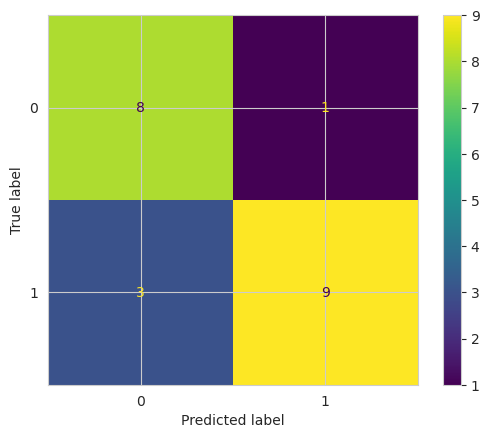

In [ ]:
lda = LinearDiscriminantAnalysis()
lda.fit(x_train,y_train)
lda_pred = lda.predict(x_test)
cm  = confusion_matrix(y_test,lda_pred)
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=lda.classes_)
disp.plot()
print('\n')
print(classification_report(y_test,lda_pred))

In [ ]:
# Calculate all
precision,recall,f1_score = evaluate_fn(y_test, lda_pred)  # takes y_test and model pred
print("precision : ",precision,'\n',"recall :",recall,'\n',"f1_score :",f1_score)
print("\n")
acc = k_evaluate(10, lda, new_data, y)  # here k 10

precision :  0.8888888888888888 
 recall : 0.7272727272727273 
 f1_score : 0.7999999999999999


for fold: 2, accuracy is: 0.7058823529411764
for fold: 3, accuracy is: 0.8431372549019608
for fold: 4, accuracy is: 0.8819230769230769
for fold: 5, accuracy is: 0.8609523809523809
for fold: 6, accuracy is: 0.8627450980392157
for fold: 7, accuracy is: 0.8605442176870748
for fold: 8, accuracy is: 0.891025641025641
for fold: 9, accuracy is: 0.8914141414141413
for fold: 10, accuracy is: 0.8818181818181818
Best fit
9 gives accuracy of 0.8914141414141413


### Decision Tree

[[ 8  1]
 [ 2 10]]


              precision    recall  f1-score   support

           0       0.80      0.89      0.84         9
           1       0.91      0.83      0.87        12

    accuracy                           0.86        21
   macro avg       0.85      0.86      0.86        21
weighted avg       0.86      0.86      0.86        21



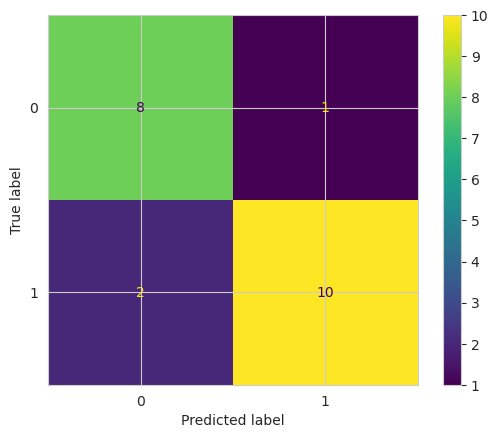

In [ ]:
dt = DecisionTreeClassifier(criterion='entropy', random_state=0)
dt.fit(x_train,y_train)
dt_pred = dt.predict(x_test)
cm = confusion_matrix(y_test,dt_pred)
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=dt.classes_)
disp.plot()
print('\n')
print(classification_report(y_test,dt_pred))


In [ ]:
# Calculate all
precision,recall,f1_score = evaluate_fn(y_test, dt_pred)  # takes y_test and model pred
print("precision : ",precision,'\n',"recall :",recall,'\n',"f1_score :",f1_score)
print("\n")

acc = k_evaluate(10, dt, new_data, y)  # here k 10

precision :  0.8888888888888888 
 recall : 0.8 
 f1_score : 0.8421052631578948


for fold: 2, accuracy is: 0.7941176470588236
for fold: 3, accuracy is: 0.8137254901960783
for fold: 4, accuracy is: 0.8126923076923077
for fold: 5, accuracy is: 0.8433333333333334
for fold: 6, accuracy is: 0.8137254901960783
for fold: 7, accuracy is: 0.7836734693877551
for fold: 8, accuracy is: 0.8830128205128205
for fold: 9, accuracy is: 0.8518518518518519
for fold: 10, accuracy is: 0.8218181818181819
Best fit
8 gives accuracy of 0.8830128205128205


### Random Forest

[[ 9  0]
 [ 2 10]]


              precision    recall  f1-score   support

           0       0.82      1.00      0.90         9
           1       1.00      0.83      0.91        12

    accuracy                           0.90        21
   macro avg       0.91      0.92      0.90        21
weighted avg       0.92      0.90      0.91        21



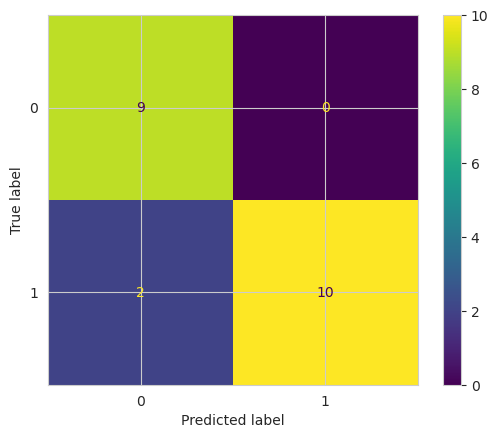

In [ ]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(x_train, y_train)
y_pred = rf_classifier.predict(x_test)

cm = confusion_matrix(y_test,y_pred)
print(cm)
print('\n')
print(classification_report(y_test,y_pred))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=rf_classifier.classes_)
disp.plot()

In [ ]:
# Calculate all
precision,recall,f1_score = evaluate_fn(y_test, y_pred)  # takes y_test and model pred
print("precision : ",precision,'\n',"recall :",recall,'\n',"f1_score :",f1_score)
print("\n")
# K-Fold
acc = k_evaluate(10, rf_classifier, new_x, y)

precision :  1.0 
 recall : 0.8181818181818182 
 f1_score : 0.9


for fold: 2, accuracy is: 0.7450980392156863
for fold: 3, accuracy is: 0.8431372549019608
for fold: 4, accuracy is: 0.8819230769230769
for fold: 5, accuracy is: 0.900952380952381
for fold: 6, accuracy is: 0.8823529411764707
for fold: 7, accuracy is: 0.9122448979591837
for fold: 8, accuracy is: 0.8733974358974359
for fold: 9, accuracy is: 0.9023569023569024
for fold: 10, accuracy is: 0.860909090909091
Best fit
7 gives accuracy of 0.9122448979591837


<a name=GA></a>
# GA(Genetic Algorithm)

## Implementation


In [ ]:
def init_position(lb, ub, N, dim):
    X = np.zeros([N, dim], dtype='float')
    for i in range(N):
        for d in range(dim):
            X[i,d] = lb[0,d] + (ub[0,d] - lb[0,d]) * rand()

    return X

def binary_conversion(X, thres, N, dim):
    Xbin = np.zeros([N, dim], dtype='int')
    for i in range(N):
        for d in range(dim):
            if X[i,d] > thres:
                Xbin[i,d] = 1
            else:
                Xbin[i,d] = 0

    return Xbin


def roulette_wheel(prob):
    num = len(prob)
    C   = np.cumsum(prob)
    P   = rand()
    for i in range(num):
        if C[i] > P:
            index = i;
            break

    return index


def genetic_search(xtrain, ytrain, opts):
    # Parameters
    ub       = 1
    lb       = 0
    thres    = 0.5
    CR       = 0.8     # crossover rate
    MR       = 0.01    # mutation rate

    N        = opts['N']
    max_iter = opts['T']
    if 'CR' in opts:
        CR   = opts['CR']
    if 'MR' in opts:
        MR   = opts['MR']

     # Dimension
    dim = np.size(xtrain, 1)
    if np.size(lb) == 1:
        ub = ub * np.ones([1, dim], dtype='float')
        lb = lb * np.ones([1, dim], dtype='float')

    # Initialize position
    X     = init_position(lb, ub, N, dim)

    # Binary conversion
    X     = binary_conversion(X, thres, N, dim)

    # Fitness at first iteration
    fit   = np.zeros([N, 1], dtype='float')
    Xgb   = np.zeros([1, dim], dtype='int')
    fitG  = float('inf')

    for i in range(N):
        fit[i,0] = Fun(xtrain, ytrain, X[i,:], opts)
        if fit[i,0] < fitG:
            Xgb[0,:] = X[i,:]
            fitG     = fit[i,0]

    # Pre
    curve = np.zeros([1, max_iter], dtype='float')
    t     = 0

    curve[0,t] = fitG.copy()
    print("Generation:", t + 1)
    print("Best (GA):", curve[0,t])
    t += 1

    while t < max_iter:
        # Probability
        inv_fit = 1 / (1 + fit)
        prob    = inv_fit / np.sum(inv_fit)

        # Number of crossovers
        Nc = 0
        for i in range(N):
            if rand() < CR:
              Nc += 1

        x1 = np.zeros([Nc, dim], dtype='int')
        x2 = np.zeros([Nc, dim], dtype='int')
        for i in range(Nc):
            # Parent selection
            k1      = roulette_wheel(prob)
            k2      = roulette_wheel(prob)
            P1      = X[k1,:].copy()
            P2      = X[k2,:].copy()
            # Random one dimension from 1 to dim
            index   = np.random.randint(low = 1, high = dim-1)
            # Crossover
            x1[i,:] = np.concatenate((P1[0:index] , P2[index:]))
            x2[i,:] = np.concatenate((P2[0:index] , P1[index:]))
            # Mutation
            for d in range(dim):
                if rand() < MR:
                    x1[i,d] = 1 - x1[i,d]

                if rand() < MR:
                    x2[i,d] = 1 - x2[i,d]


        # Merge two group into one
        Xnew = np.concatenate((x1 , x2), axis=0)

        # Fitness
        Fnew = np.zeros([2 * Nc, 1], dtype='float')
        for i in range(2 * Nc):
            Fnew[i,0] = Fun(xtrain, ytrain, Xnew[i,:], opts)
            if Fnew[i,0] < fitG:
                Xgb[0,:] = Xnew[i,:]
                fitG     = Fnew[i,0]

        # Store result
        curve[0,t] = fitG.copy()
        print("Generation:", t + 1)
        print("Best (GA):", curve[0,t])
        t += 1

        # Elitism
        XX  = np.concatenate((X , Xnew), axis=0)
        FF  = np.concatenate((fit , Fnew), axis=0)
        # Sort in ascending order
        ind = np.argsort(FF, axis=0)
        for i in range(N):
            X[i,:]   = XX[ind[i,0],:]
            fit[i,0] = FF[ind[i,0]].item()


    # Best feature subset
    Gbin       = Xgb[0,:]
    Gbin       = Gbin.reshape(dim)
    pos        = np.asarray(range(0, dim))
    sel_index  = pos[Gbin == 1]
    num_feat   = len(sel_index)
    # Create dictionary
    ga_data = {'sf': sel_index, 'c': curve, 'nf': num_feat}

    return ga_data

In [ ]:
# from FS.ga import jfs

In [ ]:
# grab our features
y = data['response']
Y = y.values
x = data.drop(['response'], axis= 1)
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, Y, test_size = 0.2, random_state = 101)
print("x_train shape: ", x_train.shape)
print("y_train shape: ", y_train.shape)
print("x_text: ",x_test.shape)
print("y_test: ",y_test.shape)

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

x_train shape:  (81, 6033)
y_train shape:  (81,)
x_text:  (21, 6033)
y_test:  (21,)


In [ ]:
# parameter
k    = 5     # k-value in KNN
N    = 10    # number of chromosomes
T    = 100   # maximum number of generations
CR   = 0.8
MR   = 0.01

fold = {'xt':x_train, 'yt':y_train, 'xv':x_test, 'yv':y_test}

opts = {'k':k, 'fold':fold, 'N':N, 'T':T, 'CR':CR, 'MR':MR}

X = x.to_numpy()



In [ ]:
# perform feature selection
fmdl = genetic_search(x, y, opts)
sf   = fmdl['sf']

Generation: 1
Best (GA): 0.09922852880585352
Generation: 2
Best (GA): 0.09920366555374013
Generation: 3
Best (GA): 0.09918709005233123
Generation: 4
Best (GA): 0.09916719945064052
Generation: 5
Best (GA): 0.09916719945064052
Generation: 6
Best (GA): 0.052039260259051465
Generation: 7
Best (GA): 0.052039260259051465
Generation: 8
Best (GA): 0.052039260259051465
Generation: 9
Best (GA): 0.052039260259051465
Generation: 10
Best (GA): 0.052039260259051465
Generation: 11
Best (GA): 0.052039260259051465
Generation: 12
Best (GA): 0.052034287608628785
Generation: 13
Best (GA): 0.05200279415595185
Generation: 14
Best (GA): 0.05200279415595185
Generation: 15
Best (GA): 0.05197793090383847
Generation: 16
Best (GA): 0.05197793090383847
Generation: 17
Best (GA): 0.05197793090383847
Generation: 18
Best (GA): 0.05197793090383847
Generation: 19
Best (GA): 0.05193814970045706
Generation: 20
Best (GA): 0.05193814970045706
Generation: 21
Best (GA): 0.05192488929932993
Generation: 22
Best (GA): 0.05191494

## Data Preparation

In [ ]:
# model with selected features
num_train = np.size(x_train, 0)
num_valid = np.size(x_test, 0)
x_train   = x_train[:, sf]
y_train   = y_train.reshape(num_train)
x_valid   = x_test[:, sf]
y_valid   = y_test.reshape(num_valid)

In [ ]:
f = fmdl['sf']   ## its 11
# featching features
features = []
for key, val in col_dict.items():
  if key in f:
    features.append(col_dict.get(key))
print(len(features))

2580


In [ ]:
new_x = x[features]
new_x.head()

V2        V4        V6        V8        V9       V10       V13  \
86 -0.882561 -0.882561 -0.021115  4.741596 -0.788777 -0.882561 -0.882561   
29 -0.849856 -0.849856 -0.849856  4.516182 -0.849856 -0.849856 -0.849856   
0  -0.740039 -1.097891  0.018752  3.959997 -0.398219 -1.097891 -1.097891   
82 -0.080795 -0.943168 -0.763574  5.087308 -0.943168 -0.943168 -0.943168   
73 -1.000187 -1.000187 -1.000187  4.869576 -0.536834 -1.000187 -1.000187   

         V14       V15       V17  ...     V6008     V6010     V6011     V6018  \
86  1.187869  1.735087  1.610551  ... -0.882561 -0.882561  0.019053 -0.882561   
29  0.808056  2.028276  1.768994  ... -0.849856 -0.007345  0.031940 -0.284197   
0   0.301076 -1.097891  0.606712  ... -1.097891  0.516282 -1.097891 -0.554321   
82  2.296044  2.400563  2.342703  ... -0.943168 -0.260390 -0.310916 -0.943168   
73  1.259905  1.636118  1.892151  ... -1.000187 -0.741535 -0.367416 -0.600460   

       V6019     V6020     V6023     V6026     V6032     V6033  
86 -0.624399  1.246110  1.402627 -0.882561 -0.882561 -0.882561  
29 -0.135850  1.736805  1.063183 -0.849856 -0.849856 -0.232165  
0   0.801917 -0.019739  2.025465 -1.097891 -0.452616  0.194001  
82 -0.364174  1.684162  1.870573 -0.943168 -0.260390 -0.943168  
73  0.234848  1.208813  1.860175 -1.000187 -1.000187 -0.058197  

[5 rows x 2580 columns]

<a name=GC></a>
## Classification

### SVC

[[8 1]
 [3 9]]


              precision    recall  f1-score   support

           0       0.73      0.89      0.80         9
           1       0.90      0.75      0.82        12

    accuracy                           0.81        21
   macro avg       0.81      0.82      0.81        21
weighted avg       0.83      0.81      0.81        21

              precision    recall  f1-score   support

           0       0.73      0.89      0.80         9
           1       0.90      0.75      0.82        12

    accuracy                           0.81        21
   macro avg       0.81      0.82      0.81        21
weighted avg       0.83      0.81      0.81        21



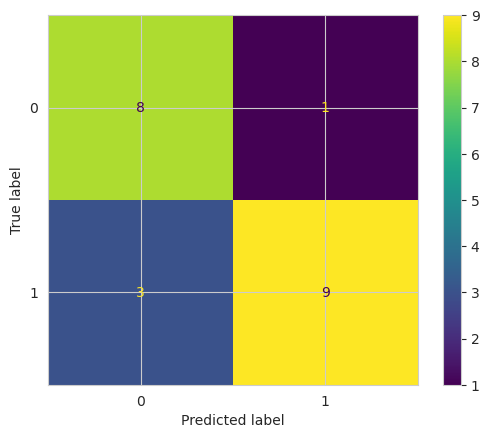

In [ ]:
model = SVC()
model.fit(x_train, y_train)
model_pred = model.predict(x_valid)
cm = confusion_matrix(y_valid,model_pred)
print(cm)
print('\n')
print(classification_report(y_test,model_pred))

disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
disp.plot()
print(classification_report(y_valid,model_pred))

In [ ]:
# K-FOLD cross validatoion
acc = k_evaluate(10, model, new_x, y)  # here k 10

for fold: 2, accuracy is: 0.6470588235294118
for fold: 3, accuracy is: 0.7745098039215685
for fold: 4, accuracy is: 0.823076923076923
for fold: 5, accuracy is: 0.813809523809524
for fold: 6, accuracy is: 0.8529411764705882
for fold: 7, accuracy is: 0.8632653061224488
for fold: 8, accuracy is: 0.8733974358974359
for fold: 9, accuracy is: 0.8636363636363636
for fold: 10, accuracy is: 0.8818181818181818
Best fit
10 gives accuracy of 0.8818181818181818


### Naive Bayes

[[6 3]
 [5 7]]


              precision    recall  f1-score   support

           0       0.55      0.67      0.60         9
           1       0.70      0.58      0.64        12

    accuracy                           0.62        21
   macro avg       0.62      0.62      0.62        21
weighted avg       0.63      0.62      0.62        21



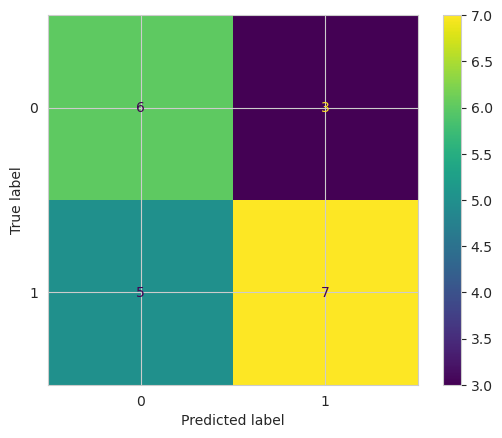

In [ ]:
gnb = GaussianNB()
gnb.fit(x_train, y_train)

y_pred = gnb.predict(x_valid)
cm = confusion_matrix(y_valid,y_pred)
print(cm)
print('\n')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=gnb.classes_)
disp.plot()
print(classification_report(y_valid,y_pred))

In [ ]:
# Calculate all
precision,recall,f1_score = evaluate_fn(y_test, y_pred)  # takes y_test and model pred
print("precision : ",precision,'\n',"recall :",recall,'\n',"f1_score :",f1_score)

# K-Fold
acc = k_evaluate(10, gnb, new_x, y)

precision :  0.6666666666666666 
 recall : 0.5454545454545454 
 f1_score : 0.6
for fold: 2, accuracy is: 0.5588235294117647
for fold: 3, accuracy is: 0.5784313725490197
for fold: 4, accuracy is: 0.5788461538461539
for fold: 5, accuracy is: 0.5995238095238095
for fold: 6, accuracy is: 0.6078431372549019
for fold: 7, accuracy is: 0.6095238095238095
for fold: 8, accuracy is: 0.5993589743589743
for fold: 9, accuracy is: 0.611952861952862
for fold: 10, accuracy is: 0.6109090909090908
Best fit
9 gives accuracy of 0.611952861952862


### LDA

[[8 1]
 [3 9]]


              precision    recall  f1-score   support

           0       0.73      0.89      0.80         9
           1       0.90      0.75      0.82        12

    accuracy                           0.81        21
   macro avg       0.81      0.82      0.81        21
weighted avg       0.83      0.81      0.81        21

              precision    recall  f1-score   support

           0       0.73      0.89      0.80         9
           1       0.90      0.75      0.82        12

    accuracy                           0.81        21
   macro avg       0.81      0.82      0.81        21
weighted avg       0.83      0.81      0.81        21

precision :  0.8888888888888888 
 recall : 0.7272727272727273 
 f1_score : 0.7999999999999999




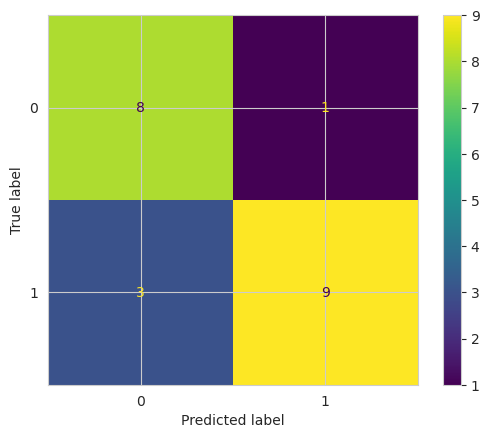

In [ ]:

lda = LinearDiscriminantAnalysis()
lda.fit(x_train,y_train)
lda_pred = lda.predict(x_valid)
cm = confusion_matrix(y_valid,lda_pred)
print(cm)
print('\n')
print(classification_report(y_valid,lda_pred))

disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=lda.classes_)
disp.plot()
print(classification_report(y_valid,lda_pred))

# Calculate all
precision,recall,f1_score = evaluate_fn(y_valid, lda_pred)  # takes y_test and model pred
print("precision : ",precision,'\n',"recall :",recall,'\n',"f1_score :",f1_score)
print('\n')

In [ ]:
# K-FOLD Cross Validation
acc = k_evaluate(10, lda, new_x, y)  # here k 10

for fold: 2, accuracy is: 0.7647058823529411
for fold: 3, accuracy is: 0.8333333333333334
for fold: 4, accuracy is: 0.8523076923076922
for fold: 5, accuracy is: 0.8719047619047618
for fold: 6, accuracy is: 0.8529411764705882
for fold: 7, accuracy is: 0.8816326530612244
for fold: 8, accuracy is: 0.8517628205128205
for fold: 9, accuracy is: 0.8712121212121212
for fold: 10, accuracy is: 0.891818181818182
Best fit
10 gives accuracy of 0.891818181818182


### Decision Tree

precision :  0.8888888888888888 
 recall : 0.8 
 f1_score : 0.8421052631578948
[[ 8  1]
 [ 2 10]]


              precision    recall  f1-score   support

           0       0.80      0.89      0.84         9
           1       0.91      0.83      0.87        12

    accuracy                           0.86        21
   macro avg       0.85      0.86      0.86        21
weighted avg       0.86      0.86      0.86        21

              precision    recall  f1-score   support

           0       0.80      0.89      0.84         9
           1       0.91      0.83      0.87        12

    accuracy                           0.86        21
   macro avg       0.85      0.86      0.86        21
weighted avg       0.86      0.86      0.86        21

precision :  0.8888888888888888 
 recall : 0.8 
 f1_score : 0.8421052631578948




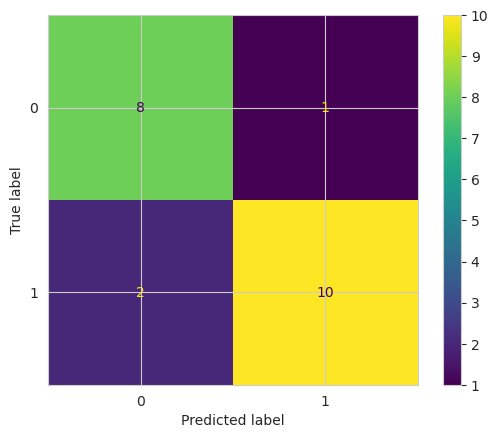

In [ ]:
dt = DecisionTreeClassifier(criterion='entropy', random_state=0)
dt.fit(x_train,y_train)
dt_pred = dt.predict(x_valid)

# Calculate all
precision,recall,f1_score = evaluate_fn(y_valid, dt_pred)  # takes y_test and model pred
print("precision : ",precision,'\n',"recall :",recall,'\n',"f1_score :",f1_score)
cm = confusion_matrix(y_valid,dt_pred)
print(cm)
print('\n')
print(classification_report(y_valid,dt_pred))

disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=dt.classes_)
disp.plot()
print(classification_report(y_valid, dt_pred))

# Calculate all
precision,recall,f1_score = evaluate_fn(y_valid, dt_pred)  # takes y_test and model pred
print("precision : ",precision,'\n',"recall :",recall,'\n',"f1_score :",f1_score)
print('\n')

In [ ]:
acc = k_evaluate(10, dt, new_x, y)  # here k 10

for fold: 2, accuracy is: 0.7647058823529411
for fold: 3, accuracy is: 0.7352941176470588
for fold: 4, accuracy is: 0.6950000000000001
for fold: 5, accuracy is: 0.7833333333333334
for fold: 6, accuracy is: 0.7450980392156863
for fold: 7, accuracy is: 0.7945578231292517
for fold: 8, accuracy is: 0.7467948717948718
for fold: 9, accuracy is: 0.7954545454545454
for fold: 10, accuracy is: 0.7854545454545454
Best fit
9 gives accuracy of 0.7954545454545454


### Random Forest

[[ 9  0]
 [ 2 10]]


              precision    recall  f1-score   support

           0       0.82      1.00      0.90         9
           1       1.00      0.83      0.91        12

    accuracy                           0.90        21
   macro avg       0.91      0.92      0.90        21
weighted avg       0.92      0.90      0.91        21



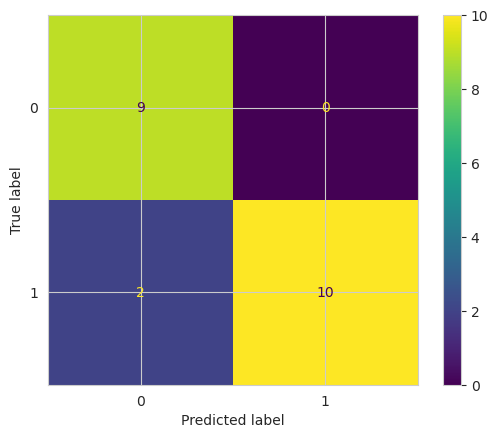

In [ ]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(x_train, y_train)
y_pred = rf_classifier.predict(x_valid)

cm = confusion_matrix(y_valid,y_pred)
print(cm)
print('\n')
print(classification_report(y_valid,y_pred))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=rf_classifier.classes_)
disp.plot()

In [ ]:
# Calculate all
precision,recall,f1_score = evaluate_fn(y_valid, y_pred)  # takes y_test and model pred
print("precision : ",precision,'\n',"recall :",recall,'\n',"f1_score :",f1_score)
print("\n")
# K-Fold
acc = k_evaluate(10, rf_classifier, new_x, y)

precision :  1.0 
 recall : 0.8181818181818182 
 f1_score : 0.9


for fold: 2, accuracy is: 0.7843137254901961
for fold: 3, accuracy is: 0.8137254901960785
for fold: 4, accuracy is: 0.861923076923077
for fold: 5, accuracy is: 0.832857142857143
for fold: 6, accuracy is: 0.8823529411764707
for fold: 7, accuracy is: 0.8639455782312925
for fold: 8, accuracy is: 0.8822115384615385
for fold: 9, accuracy is: 0.872895622895623
for fold: 10, accuracy is: 0.8609090909090911
Best fit
6 gives accuracy of 0.8823529411764707


<a name=PSO></a>
# PSO(Particle Swarm Optimization)

In [ ]:
class SVMFeatureSelection(Problem):
    def __init__(self, X_train, y_train, alpha=0.99):
        super().__init__(dimension=X_train.shape[1], lower=0, upper=1)
        self.X_train = X_train
        self.y_train = y_train
        self.alpha = alpha

    def _evaluate(self, x):
        selected = x > 0.5
        num_selected = selected.sum()
        if num_selected == 0:
            return 1.0
        accuracy = cross_val_score(SVC(), self.X_train[:, selected], self.y_train, cv=2, n_jobs=-1).mean()
        score = 1 - accuracy
        num_features = self.X_train.shape[1]
        return self.alpha * score + (1 - self.alpha) * (num_selected / num_features)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 101)
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()

print("x_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
feature_names = x.columns
feature_names

x_train shape:  (81, 6033)
y_train shape:  (81,)


Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       ...
       'V6024', 'V6025', 'V6026', 'V6027', 'V6028', 'V6029', 'V6030', 'V6031',
       'V6032', 'V6033'],
      dtype='object', length=6033)

In [ ]:
problem = SVMFeatureSelection(X_train, y_train)
task = Task(problem, max_iters=100)
algorithm = ParticleSwarmOptimization(population_size=100, seed=101)
best_features, best_fitness = algorithm.run(task)

In [ ]:
selected_features = best_features > 0.5
print('Number of selected features:', selected_features.sum())
print('Selected features:', ', '.join(feature_names[selected_features].tolist()))

Number of selected features: 2732
Selected features: V1, V4, V6, V11, V12, V14, V15, V18, V20, V23, V24, V27, V28, V29, V30, V31, V36, V39, V41, V43, V46, V50, V51, V52, V55, V56, V62, V63, V66, V68, V69, V72, V77, V78, V80, V82, V92, V93, V96, V100, V103, V104, V105, V109, V110, V111, V113, V119, V120, V123, V126, V129, V130, V132, V133, V134, V141, V147, V148, V150, V154, V158, V159, V165, V168, V170, V173, V174, V177, V179, V182, V184, V189, V192, V195, V197, V199, V202, V203, V204, V205, V211, V213, V214, V217, V218, V219, V220, V224, V228, V229, V230, V232, V233, V236, V237, V238, V243, V245, V247, V249, V250, V252, V253, V257, V263, V266, V270, V271, V273, V274, V276, V277, V278, V280, V282, V283, V286, V287, V291, V295, V296, V297, V306, V307, V308, V310, V311, V313, V315, V316, V318, V319, V324, V325, V329, V330, V332, V334, V335, V338, V340, V343, V344, V345, V346, V348, V350, V351, V354, V355, V357, V364, V366, V370, V371, V375, V379, V381, V382, V392, V394, V396, V398, V400,

In [ ]:
new_x = x[feature_names[selected_features]]
new_x.head()

V1        V4        V6       V11       V12       V14       V15  \
86 -0.882561 -0.882561 -0.021115  1.003656 -0.420086  1.187869  1.735087   
29 -0.849856 -0.849856 -0.849856  0.531204 -0.849856  0.808056  2.028276   
0  -0.927178 -1.097891  0.018752  0.183420 -1.097891  0.301076 -1.097891   
82 -0.943168 -0.943168 -0.763574  1.454042 -0.212329  2.296044  2.400563   
73 -1.000187 -1.000187 -1.000187  0.014862 -1.000187  1.259905  1.636118   

         V18       V20       V23  ...     V6019     V6020     V6022     V6024  \
86  2.952926 -0.882561  1.322257  ... -0.624399  1.246110 -0.152508 -0.360432   
29  3.183533 -0.849856  0.355746  ... -0.135850  1.736805 -0.339204 -0.339204   
0   1.420045 -1.097891  1.223614  ...  0.801917 -0.019739 -0.810672 -0.029602   
82  3.174819 -0.943168  0.699592  ... -0.364174  1.684162 -0.943168  0.771263   
73  2.900811 -0.820445  0.829841  ...  0.234848  1.208813 -1.000187 -0.058197   

       V6025     V6026     V6028     V6029     V6032     V6033  
86 -0.882561 -0.882561  0.640213 -0.360432 -0.882561 -0.882561  
29 -0.849856 -0.849856  0.238953 -0.849856 -0.849856 -0.232165  
0  -1.097891 -1.097891  0.850270 -1.097891 -0.452616  0.194001  
82 -0.943168 -0.943168  0.071049 -0.943168 -0.260390 -0.943168  
73 -1.000187 -1.000187  0.782512  0.115204 -1.000187 -0.058197  

[5 rows x 2732 columns]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(new_x, y, test_size = 0.2, random_state = 101)

<a name=PC></a>
## Classification

### SVC

Model accuracy: 0.9047619047619048
[[ 9  0]
 [ 2 10]]


              precision    recall  f1-score   support

           0       0.82      1.00      0.90         9
           1       1.00      0.83      0.91        12

    accuracy                           0.90        21
   macro avg       0.91      0.92      0.90        21
weighted avg       0.92      0.90      0.91        21



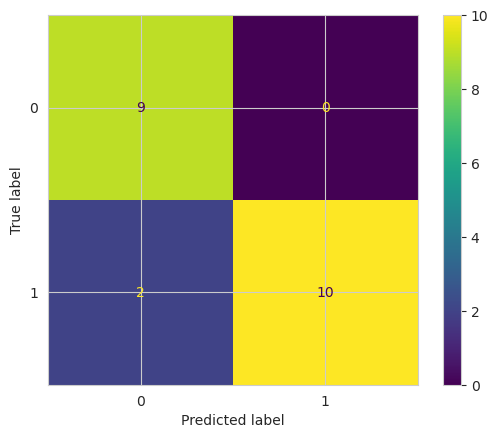

In [ ]:
model = SVC()
# X_train = sc.fit_transform(X_train[:, selected_features])
# X_test = sc.transform(X_test[:, selected_features])
model.fit(X_train, y_train)
print('Model accuracy:', model.score(X_test, y_test))

# plot confusion matrix
model_pred = model.predict(X_test)
cm = confusion_matrix(y_test,model_pred)
print(cm)
print('\n')
print(classification_report(y_test,model_pred))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
disp.plot()

In [ ]:
# Calculate all
model_pred = model.predict(X_test)
precision,recall,f1_score = evaluate_fn(y_test, model_pred)  # takes y_test and model pred
print("precision : ",precision,'\n',"recall :",recall,'\n',"f1_score :",f1_score)
print("\n")
#K-fold
acc = k_evaluate(10,model, new_x, y)  # here k 10

precision :  1.0 
 recall : 0.8181818181818182 
 f1_score : 0.9


for fold: 2, accuracy is: 0.7450980392156863
for fold: 3, accuracy is: 0.8529411764705882
for fold: 4, accuracy is: 0.8726923076923077
for fold: 5, accuracy is: 0.8919047619047618
for fold: 6, accuracy is: 0.9019607843137255
for fold: 7, accuracy is: 0.9027210884353742
for fold: 8, accuracy is: 0.9022435897435896
for fold: 9, accuracy is: 0.9023569023569024
for fold: 10, accuracy is: 0.891818181818182
Best fit
7 gives accuracy of 0.9027210884353742


### LDA

Subset accuracy: 0.8095238095238095
[[8 1]
 [3 9]]


              precision    recall  f1-score   support

           0       0.73      0.89      0.80         9
           1       0.90      0.75      0.82        12

    accuracy                           0.81        21
   macro avg       0.81      0.82      0.81        21
weighted avg       0.83      0.81      0.81        21



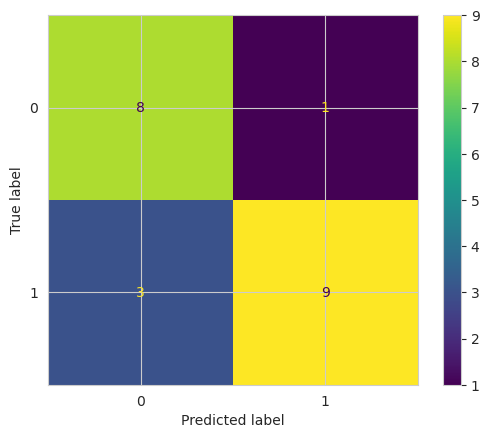

In [ ]:
lda = LinearDiscriminantAnalysis()

lda.fit(X_train, y_train)
print('Subset accuracy:', lda.score(X_test, y_test))

# plot confusion matrix
model_pred = lda.predict(X_test)
cm = confusion_matrix(y_test,model_pred)
print(cm)
print('\n')
print(classification_report(y_test,model_pred))

disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=lda.classes_)
disp.plot()

In [ ]:
# Calculate all
model_pred = lda.predict(X_test)
precision,recall,f1_score = evaluate_fn(y_test, model_pred)  # takes y_test and model pred
print("precision : ",precision,'\n',"recall :",recall,'\n',"f1_score :",f1_score)
print("\n")

#k-fold
acc = k_evaluate(10, lda, new_x, y)  # here k 10

precision :  0.8888888888888888 
 recall : 0.7272727272727273 
 f1_score : 0.7999999999999999


for fold: 2, accuracy is: 0.7549019607843137
for fold: 3, accuracy is: 0.8431372549019608
for fold: 4, accuracy is: 0.8819230769230769
for fold: 5, accuracy is: 0.8814285714285715
for fold: 6, accuracy is: 0.8529411764705882
for fold: 7, accuracy is: 0.8714285714285713
for fold: 8, accuracy is: 0.8717948717948718
for fold: 9, accuracy is: 0.8703703703703703
for fold: 10, accuracy is: 0.8809090909090911
Best fit
4 gives accuracy of 0.8819230769230769


### Decision Tree

Subset accuracy: 0.8571428571428571
[[9 0]
 [3 9]]


              precision    recall  f1-score   support

           0       0.75      1.00      0.86         9
           1       1.00      0.75      0.86        12

    accuracy                           0.86        21
   macro avg       0.88      0.88      0.86        21
weighted avg       0.89      0.86      0.86        21



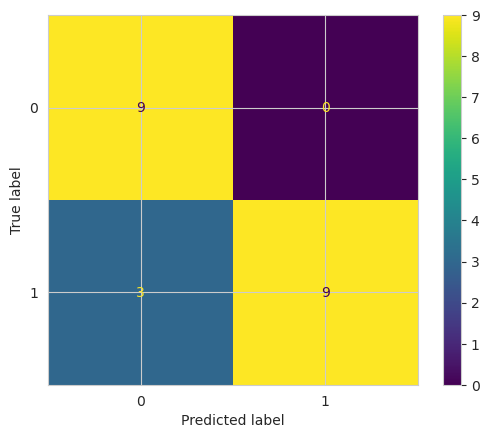

In [ ]:
dt = DecisionTreeClassifier(criterion='entropy', random_state=0)

# X_train = sc.fit_transform(X_train[:, selected_features])
# X_test = sc.transform(X_test[:, selected_features])
dt.fit(X_train, y_train)
print('Subset accuracy:', dt.score(X_test, y_test))

# plot confusion matrix
model_pred = dt.predict(X_test)
cm = confusion_matrix(y_test,model_pred)
print(cm)
print('\n')
print(classification_report(y_test,model_pred))

disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=dt.classes_)
disp.plot()

In [ ]:
# Calculate all
model_pred = dt.predict(X_test)
precision,recall,f1_score = evaluate_fn(y_test, model_pred)  # takes y_test and model pred
print("precision : ",precision,'\n',"recall :",recall,'\n',"f1_score :",f1_score)
print("\n")

#k-fold
acc = k_evaluate(10,dt, new_x, y)  # here k 10

precision :  1.0 
 recall : 0.75 
 f1_score : 0.8571428571428571


for fold: 2, accuracy is: 0.8333333333333333
for fold: 3, accuracy is: 0.8529411764705882
for fold: 4, accuracy is: 0.8338461538461539
for fold: 5, accuracy is: 0.813809523809524
for fold: 6, accuracy is: 0.8431372549019608
for fold: 7, accuracy is: 0.8238095238095238
for fold: 8, accuracy is: 0.8629807692307692
for fold: 9, accuracy is: 0.8417508417508418
for fold: 10, accuracy is: 0.8318181818181818
Best fit
8 gives accuracy of 0.8629807692307692


### Random Forest

[[8 1]
 [3 9]]


              precision    recall  f1-score   support

           0       0.73      0.89      0.80         9
           1       0.90      0.75      0.82        12

    accuracy                           0.81        21
   macro avg       0.81      0.82      0.81        21
weighted avg       0.83      0.81      0.81        21



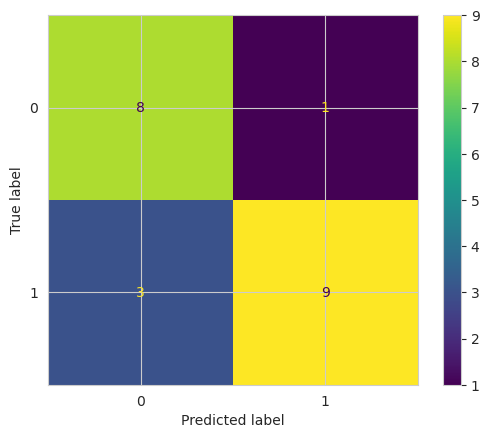

In [ ]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_test)
cm = confusion_matrix(y_test,y_pred)
print(cm)
print('\n')
print(classification_report(y_test,y_pred))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=rf_classifier.classes_)
disp.plot()

In [ ]:
# Calculate all
precision,recall,f1_score = evaluate_fn(y_test, y_pred)  # takes y_test and model pred
print("precision : ",precision,'\n',"recall :",recall,'\n',"f1_score :",f1_score)
print("\n")
# K-Fold
acc = k_evaluate(10, rf_classifier, new_x, y)

precision :  0.8888888888888888 
 recall : 0.7272727272727273 
 f1_score : 0.7999999999999999


for fold: 2, accuracy is: 0.803921568627451
for fold: 3, accuracy is: 0.8725490196078431
for fold: 4, accuracy is: 0.881923076923077
for fold: 5, accuracy is: 0.8919047619047618
for fold: 6, accuracy is: 0.8823529411764706
for fold: 7, accuracy is: 0.9312925170068028
for fold: 8, accuracy is: 0.921474358974359
for fold: 9, accuracy is: 0.9116161616161617
for fold: 10, accuracy is: 0.901818181818182
Best fit
7 gives accuracy of 0.9312925170068028


### Naive Bayes

[[6 3]
 [5 7]]


              precision    recall  f1-score   support

           0       0.55      0.67      0.60         9
           1       0.70      0.58      0.64        12

    accuracy                           0.62        21
   macro avg       0.62      0.62      0.62        21
weighted avg       0.63      0.62      0.62        21



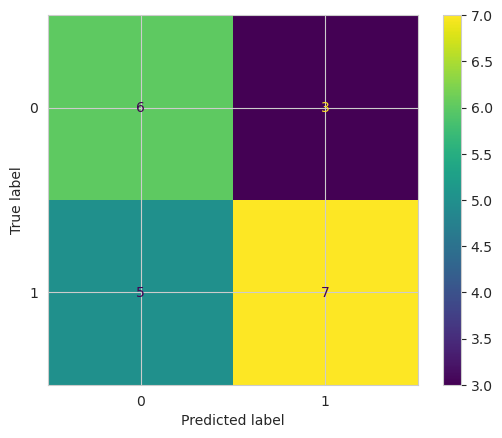

In [ ]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)

y_pred = gnb.predict(X_test)
cm = confusion_matrix(y_test,y_pred)
print(cm)
print('\n')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=gnb.classes_)
disp.plot()
print(classification_report(y_test,y_pred))

In [ ]:
# Calculate all
precision,recall,f1_score = evaluate_fn(y_test, y_pred)  # takes y_test and model pred
print("precision : ",precision,'\n',"recall :",recall,'\n',"f1_score :",f1_score)

# K-Fold
acc = k_evaluate(10, gnb, new_x, y)

precision :  0.6666666666666666 
 recall : 0.5454545454545454 
 f1_score : 0.6
for fold: 2, accuracy is: 0.5686274509803921
for fold: 3, accuracy is: 0.5784313725490197
for fold: 4, accuracy is: 0.5884615384615385
for fold: 5, accuracy is: 0.6285714285714286
for fold: 6, accuracy is: 0.6078431372549019
for fold: 7, accuracy is: 0.6190476190476192
for fold: 8, accuracy is: 0.6185897435897436
for fold: 9, accuracy is: 0.611952861952862
for fold: 10, accuracy is: 0.6209090909090909
Best fit
5 gives accuracy of 0.6285714285714286


<a name=HGJ></a>
# Hybrid GWO with JAYA

In [ ]:
# import os
# os.chdir("/content/drive/MyDrive/Adv Machine Learning")
# os.listdir()

['Wrapper-Feature-Selection-Toolbox-Python-main']

In [ ]:
# %cd 'Wrapper-Feature-Selection-Toolbox-Python-main'

/content/drive/.shortcut-targets-by-id/1ptBWQJYa6Ld65HrO2GSN9tBSFrWsVgXE/Adv Machine Learning/Wrapper-Feature-Selection-Toolbox-Python-main


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from FS.GWOJA import jfs   # change this to switch algorithm

In [ ]:

# grab our features
y = data['response']
y = y.values
x = data.drop(['response'], axis= 1)
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 101)
print("x_train shape: ", x_train.shape)
print("y_train shape: ", y_train.shape)
print("x_text: ",x_test.shape)
print("y_test: ",y_test.shape)

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

x_train shape:  (81, 6033)
y_train shape:  (81,)
x_text:  (21, 6033)
y_test:  (21,)


In [ ]:
# parameter
k    = 5     # k-value in KNN
N    = 10    # number of chromosomes
T    = 100   # maximum number of generations
CR   = 0.8
MR   = 0.01
fold = {'xt':x_train, 'yt':y_train, 'xv':x_test, 'yv':y_test}
x = x.to_numpy()
opts = {'k':k, 'fold':fold, 'N':N, 'T':T, 'CR':CR, 'MR':MR}


In [ ]:
# Check for types of x and y wheather they are numpy.ndarray or not
# y = y.values
print(type(x))
print(type(y))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [ ]:
fmdl = jfs(x, y, opts)
sf   = fmdl['sf']

Iteration: 1
Best (GWO): 0.09923350145627619
Iteration: 2
Best (GWOJA): 0.099052828490919
Iteration: 3
Best (GWOJA): 0.0988489498235893
Iteration: 4
Best (GWOJA): 0.09865667400724586
Iteration: 5
Best (GWOJA): 0.09844450758921171
Iteration: 6
Best (GWOJA): 0.09820747791906419
Iteration: 7
Best (GWOJA): 0.09805498330610214
Iteration: 8
Best (GWOJA): 0.09793398214581706
Iteration: 9
Best (GWOJA): 0.050612109587743655
Iteration: 10
Best (GWOJA): 0.050612109587743655
Iteration: 11
Best (GWOJA): 0.050408230920413966
Iteration: 12
Best (GWOJA): 0.05034358646491919
Iteration: 13
Best (GWOJA): 0.05034358646491919
Iteration: 14
Best (GWOJA): 0.05034358646491919
Iteration: 15
Best (GWOJA): 0.05034358646491919
Iteration: 16
Best (GWOJA): 0.05034358646491919
Iteration: 17
Best (GWOJA): 0.05013142004688505
Iteration: 18
Best (GWOJA): 0.050000473585754594
Iteration: 19
Best (GWOJA): 0.049950747081527844
Iteration: 20
Best (GWOJA): 0.04986455447420147
Iteration: 21
Best (GWOJA): 0.04975018351447994
I

In [ ]:
# model with selected features
num_train = np.size(x_train, 0)
num_valid = np.size(x_test, 0)
x_train   = x_train[:, sf]
y_train   = y_train.reshape(num_train)  # Solve bug
x_valid   = x_test[:, sf]
y_valid   = y_test.reshape(num_valid)  # Solve bug

In [ ]:
f = fmdl['sf']   ## its 11
# featching features
features = []
for key, val in col_dict.items():
  if key in f:
    features.append(col_dict.get(key))
print(len(features))

864


<Axes: >

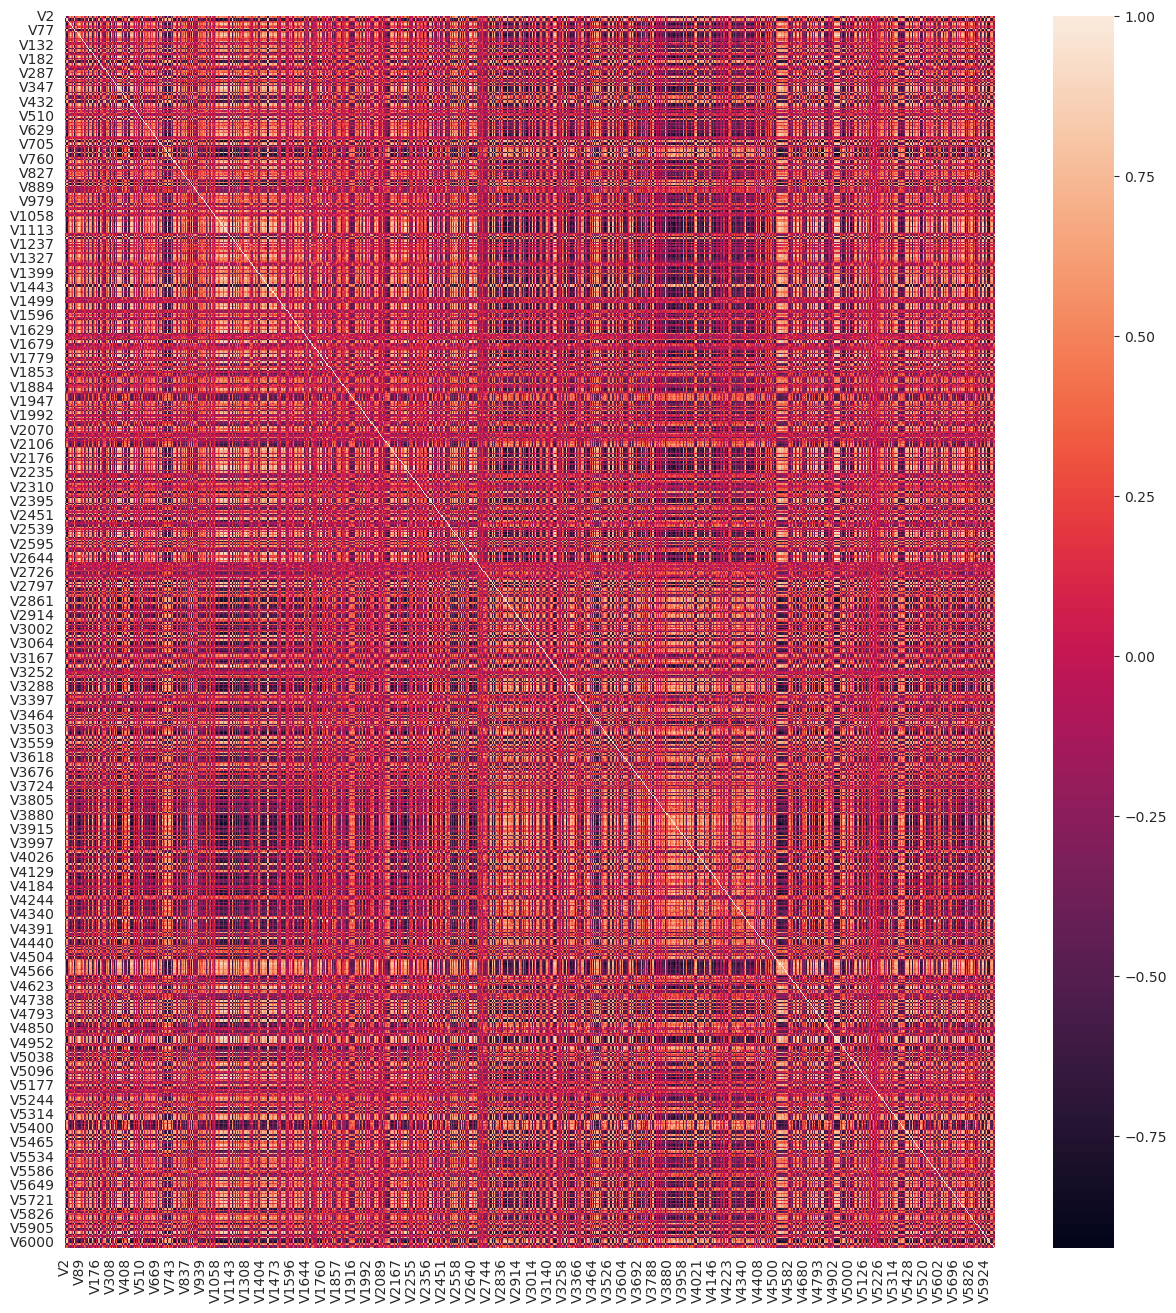

In [ ]:
cor = data[features].corr()
plt.figure(figsize=(15,16))
sns.heatmap(cor)

<a name=HC></a>
## Classification

### SVM

[[9 0]
 [3 9]]


              precision    recall  f1-score   support

           0       0.75      1.00      0.86         9
           1       1.00      0.75      0.86        12

    accuracy                           0.86        21
   macro avg       0.88      0.88      0.86        21
weighted avg       0.89      0.86      0.86        21



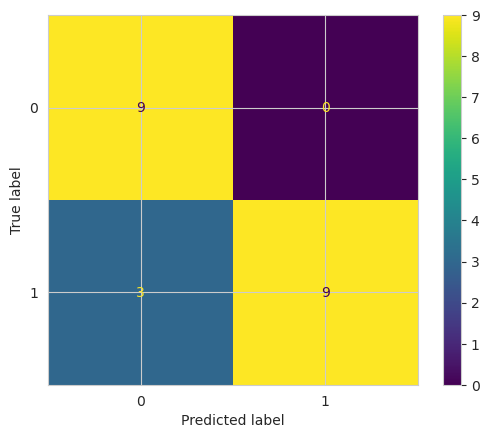

In [ ]:
# Model
model = SVC()
model.fit(x_train,y_train)
model_pred = model.predict(x_valid)
cm = confusion_matrix(y_valid,model_pred)
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
disp.plot()

print('\n')
print(classification_report(y_valid,model_pred))

In [ ]:
# Calculate all
precision,recall,f1_score = evaluate_fn(y_valid, model_pred)  # takes y_test and model pred
print("precision : ",precision,'\n',"recall :",recall,'\n',"f1_score :",f1_score)

precision :  1.0 
 recall : 0.75 
 f1_score : 0.8571428571428571


In [ ]:
#Kfold
acc = k_evaluate(10,model, x[:, sf], y)  # here k 10

for fold: 2, accuracy is: 0.7254901960784313
for fold: 3, accuracy is: 0.8627450980392156
for fold: 4, accuracy is: 0.8919230769230769
for fold: 5, accuracy is: 0.8819047619047617
for fold: 6, accuracy is: 0.9117647058823529
for fold: 7, accuracy is: 0.9122448979591837
for fold: 8, accuracy is: 0.9022435897435898
for fold: 9, accuracy is: 0.9116161616161617
for fold: 10, accuracy is: 0.900909090909091
Best fit
7 gives accuracy of 0.9122448979591837


### LDA

[[9 0]
 [3 9]]


              precision    recall  f1-score   support

           0       0.75      1.00      0.86         9
           1       1.00      0.75      0.86        12

    accuracy                           0.86        21
   macro avg       0.88      0.88      0.86        21
weighted avg       0.89      0.86      0.86        21



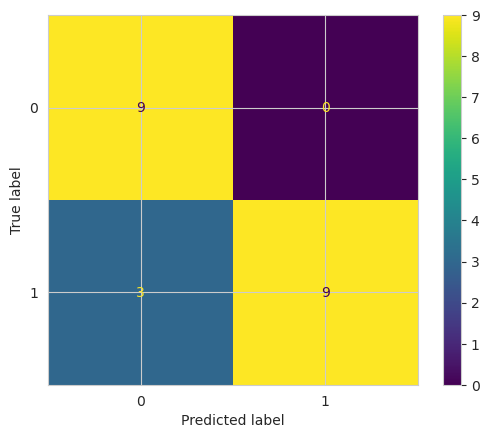

In [ ]:
lda = LinearDiscriminantAnalysis()
lda.fit(x_train,y_train)
lda_pred = lda.predict(x_valid)
confusion_matrix(y_valid,lda_pred)
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=lda.classes_)
disp.plot()
print('\n')
print(classification_report(y_valid,lda_pred))

In [ ]:
# Calculate all
precision,recall,f1_score = evaluate_fn(y_valid, lda_pred)  # takes y_test and model pred
print("precision : ",precision,'\n',"recall :",recall,'\n',"f1_score :",f1_score)

precision :  1.0 
 recall : 0.75 
 f1_score : 0.8571428571428571


In [ ]:
#Kfold
acc = k_evaluate(10,lda, x[:, sf], y)  # here k 10

for fold: 2, accuracy is: 0.7843137254901961
for fold: 3, accuracy is: 0.8039215686274509
for fold: 4, accuracy is: 0.8719230769230769
for fold: 5, accuracy is: 0.881904761904762
for fold: 6, accuracy is: 0.9117647058823529
for fold: 7, accuracy is: 0.880952380952381
for fold: 8, accuracy is: 0.8822115384615384
for fold: 9, accuracy is: 0.9006734006734006
for fold: 10, accuracy is: 0.900909090909091
Best fit
6 gives accuracy of 0.9117647058823529


### Decision Tree

[[ 7  2]
 [ 2 10]]


              precision    recall  f1-score   support

           0       0.78      0.78      0.78         9
           1       0.83      0.83      0.83        12

    accuracy                           0.81        21
   macro avg       0.81      0.81      0.81        21
weighted avg       0.81      0.81      0.81        21



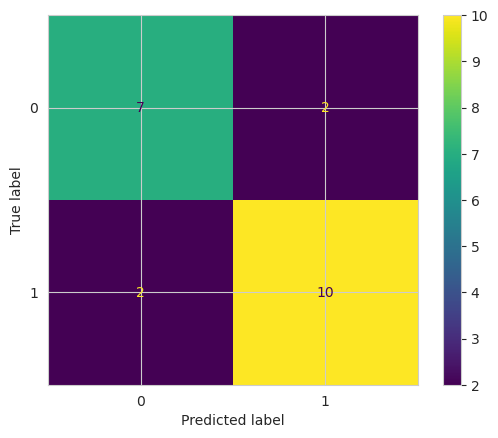

In [ ]:
dt = DecisionTreeClassifier(criterion='entropy', random_state=0)
dt.fit(x_train, y_train)
dt_pred = dt.predict(x_valid)
cm = confusion_matrix(y_valid,dt_pred)
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=dt.classes_)
disp.plot()
print('\n')
print(classification_report(y_valid,dt_pred))


In [ ]:
# Calculate all
precision,recall,f1_score = evaluate_fn(y_valid, dt_pred)  # takes y_test and model pred
print("precision : ",precision,'\n',"recall :",recall,'\n',"f1_score :",f1_score)

precision :  0.7777777777777778 
 recall : 0.7777777777777778 
 f1_score : 0.7777777777777778


In [ ]:
#Kfold
acc = k_evaluate(10,dt, x[:, sf], y)  # here k 10

for fold: 2, accuracy is: 0.7941176470588236
for fold: 3, accuracy is: 0.8039215686274509
for fold: 4, accuracy is: 0.8526923076923076
for fold: 5, accuracy is: 0.8533333333333333
for fold: 6, accuracy is: 0.8627450980392156
for fold: 7, accuracy is: 0.8625850340136053
for fold: 8, accuracy is: 0.8533653846153846
for fold: 9, accuracy is: 0.8038720538720538
for fold: 10, accuracy is: 0.8227272727272729
Best fit
6 gives accuracy of 0.8627450980392156


### Naive Bayes

[[8 1]
 [5 7]]


              precision    recall  f1-score   support

           0       0.62      0.89      0.73         9
           1       0.88      0.58      0.70        12

    accuracy                           0.71        21
   macro avg       0.75      0.74      0.71        21
weighted avg       0.76      0.71      0.71        21



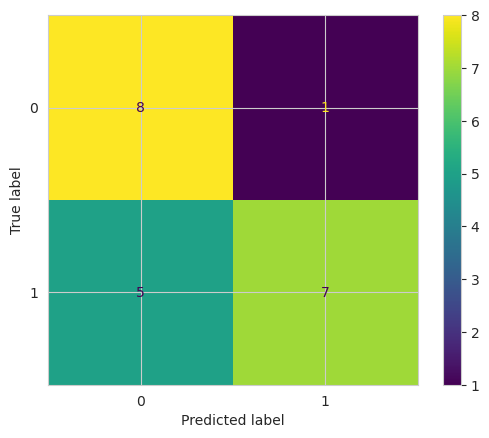

In [ ]:
gnb = GaussianNB()
gnb.fit(x_train, y_train)

y_pred = gnb.predict(x_valid)
cm = confusion_matrix(y_valid,y_pred)
print(cm)
print('\n')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=gnb.classes_)
disp.plot()
print(classification_report(y_valid,y_pred))

In [ ]:
# Calculate all
precision,recall,f1_score = evaluate_fn(y_test, y_pred)  # takes y_test and model pred
print("precision : ",precision,'\n',"recall :",recall,'\n',"f1_score :",f1_score)

# K-Fold
acc = k_evaluate(10, gnb, x[:, sf], y)

precision :  0.8888888888888888 
 recall : 0.6153846153846154 
 f1_score : 0.7272727272727274
for fold: 2, accuracy is: 0.6176470588235294
for fold: 3, accuracy is: 0.6176470588235294
for fold: 4, accuracy is: 0.6376923076923078
for fold: 5, accuracy is: 0.6580952380952381
for fold: 6, accuracy is: 0.6568627450980392
for fold: 7, accuracy is: 0.6680272108843537
for fold: 8, accuracy is: 0.6370192307692307
for fold: 9, accuracy is: 0.6296296296296295
for fold: 10, accuracy is: 0.6599999999999999
Best fit
7 gives accuracy of 0.6680272108843537


### Random Forest

[[ 9  0]
 [ 2 10]]


              precision    recall  f1-score   support

           0       0.82      1.00      0.90         9
           1       1.00      0.83      0.91        12

    accuracy                           0.90        21
   macro avg       0.91      0.92      0.90        21
weighted avg       0.92      0.90      0.91        21



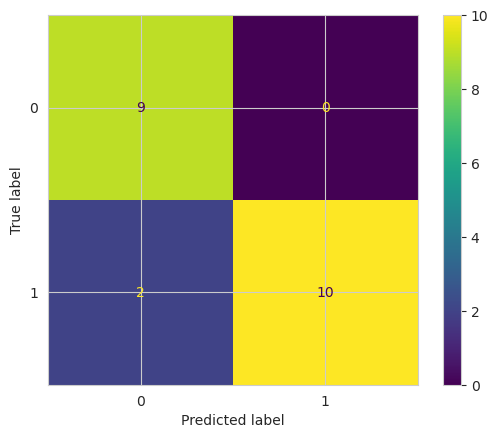

In [ ]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(x_train, y_train)
y_pred = rf_classifier.predict(x_valid)


cm = confusion_matrix(y_valid,y_pred)
print(cm)
print('\n')
print(classification_report(y_valid,y_pred))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=rf_classifier.classes_)
disp.plot()

In [ ]:
# Calculate all
precision,recall,f1_score = evaluate_fn(y_test, y_pred)  # takes y_test and model pred
print("precision : ",precision,'\n',"recall :",recall,'\n',"f1_score :",f1_score)
print("\n")
# K-Fold
acc = k_evaluate(10, rf_classifier, x[:, sf], y)

precision :  1.0 
 recall : 0.8181818181818182 
 f1_score : 0.9


for fold: 2, accuracy is: 0.7549019607843137
for fold: 3, accuracy is: 0.823529411764706
for fold: 4, accuracy is: 0.8719230769230769
for fold: 5, accuracy is: 0.8714285714285716
for fold: 6, accuracy is: 0.8823529411764707
for fold: 7, accuracy is: 0.8625850340136054
for fold: 8, accuracy is: 0.8926282051282051
for fold: 9, accuracy is: 0.9015151515151515
for fold: 10, accuracy is: 0.8809090909090911
Best fit
9 gives accuracy of 0.9015151515151515


# Support Vector Machines (SVM) with Recursive Feature Elimination (RFE): SVM-RFE

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score

# grab our features
x = data.drop(['response'], axis=1)
# grab lables
y = data.response  # label
# len(y)
# y[0]
def cvt(str):
  return str.decode("utf-8")

for st in range(len(y)):
  y[st] = y[st]
# Then convert them into integer
y.replace({"normal": 0, "tumer": 1}, inplace= True)
# convert label type to float
y = y.astype(float)

# Split data
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
svm_classifier = SVC(kernel="linear")

In [ ]:
# Create the RFE object
num_features_to_select = 100  # Number of features to select
rfe = RFE(estimator=svm_classifier, n_features_to_select=num_features_to_select)


# Fit RFE to the training data
# This will take time
rfe.fit(X_train, y_train)


RFE(estimator=SVC(kernel='linear'), n_features_to_select=100)

In [ ]:
# Get the selected feature indices
selected_feature_indices = rfe.support_

# Grab our features
def get_features(selected_feature_indices):
    # convert indeses to dictionary
    feat_idxs = dict(enumerate((selected_feature_indices).flatten(), 0)) # selected_feature_indices - numpy array
    selected_feature = []
    for key, val in col_dict.items():  # col_dict - dict containing features as vales and indces as keys
        for k, v in feat_idxs.items():
            if key == k and v != False:
                selected_feature.append(col_dict.get(key))
    return selected_feature

In [ ]:
selected_feature = get_features(selected_feature_indices)
# get train and test set
X_train_selected = X_train[selected_feature]
X_test_selected = X_test[selected_feature]

#Train the SVM classifier on the selected features
svm_classifier.fit(X_train_selected, y_train)

# Make predictions on the testing data
y_pred = svm_classifier.predict(X_test_selected)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

print("########## Accuracy with K-FOLD #########")
acc = k_evaluate(10, svm_classifier, x[selected_feature], y)

Accuracy: 0.90
########## Accuracy with K-FOLD #########
for fold: 2, accuracy is: 0.9509803921568627
for fold: 3, accuracy is: 0.9607843137254902
for fold: 4, accuracy is: 0.9607692307692308
for fold: 5, accuracy is: 0.9609523809523809
for fold: 6, accuracy is: 0.9607843137254902
for fold: 7, accuracy is: 0.9619047619047619
for fold: 8, accuracy is: 0.9615384615384616
for fold: 9, accuracy is: 0.9612794612794614
for fold: 10, accuracy is: 0.96
Best fit
7 gives accuracy of 0.9619047619047619


[[16  2]
 [ 1 12]]


              precision    recall  f1-score   support

         0.0       0.94      0.89      0.91        18
         1.0       0.86      0.92      0.89        13

    accuracy                           0.90        31
   macro avg       0.90      0.91      0.90        31
weighted avg       0.91      0.90      0.90        31



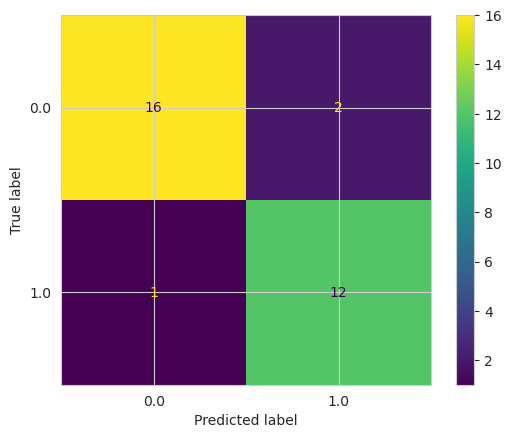

In [ ]:
cm = confusion_matrix(y_test,y_pred)
print(cm)
print('\n')

disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=svm_classifier.classes_)
disp.plot()
print(classification_report(y_test,y_pred))


# Hybrid GWOPSO

## Implementation

In [ ]:
# Error rate & Feature size
def Fun(xtrain, ytrain, x, opts):
    # Parameters
    alpha    = 0.99
    beta     = 1 - alpha
    # Original feature size
    max_feat = len(x)
    # Number of selected features
    num_feat = np.sum(x == 1)
    # Solve if no feature selected
    if num_feat == 0:
        cost  = 1
    else:
        # Get error rate
        error = error_rate(xtrain, ytrain, x, opts)
        # Objective function
        cost  = alpha * error + beta * (num_feat / max_feat)

    return cost

def fjob(x):
    term1 = (x[0] + x[1] + 1)**2 * (19 - 14*x[0] + 3*x[0]**2 - 14*x[1] + 6*x[0]*x[1] + 3*x[1]**2)
    term2 = (2*x[0] - 3*x[1])**2 * (18 - 32*x[0] + 12*x[0]**2 + 48*x[1] - 36*x[0]*x[1] + 27*x[1]**2)
    o = (1 + term1) * (30 + term2)
    return o

def init_position(lb, ub, N, dim):
  X = np.zeros([N, dim], dtype='float')
  for i in range(N):
      for d in range(dim):
          X[i,d] = lb[0,d] + (ub[0,d] - lb[0,d]) * np.random.rand()

  return X

def Get_Functions_details(xtrain):
    lb = -2
    ub = 2
    dim = 2
    dim = np.size(xtrain, 1)
    if np.size(lb) == 1:
        ub = ub * np.ones((1, 2), dtype='float')
        lb = lb * np.ones((1, 2), dtype='float')

    return [lb,ub,dim]

def binary_conversion(X, thres, num_particles, dim):
  Xbin = np.zeros([num_particles, dim], dtype='int')
  for i in range(num_particles):
      for d in range(dim):
          if X[i,d] > thres:
              Xbin[i,d] = 1
          else:
              Xbin[i,d] = 0

  return Xbin

def boundary(x, lb, ub):
  if x < lb:
      x = lb
  if x > ub:
      x = ub
  return x

In [ ]:
def GWOPSO(num_particles,Max_iter, num_features, lb, ub, xtrain):
    dim = np.size(xtrain, 1)
    Alpha_pos = np.zeros((1, dim))
    Alpha_score= float('inf')
    Beta_pos= np.zeros((1,dim))
    Beta_score= float('inf')
    Delta_pos= np.zeros((1,dim))
    Delta_score= float('inf')
    fitGP = float('inf')  # fitness GWO-PSO
    lb = -2
    ub = 2
    thres = 0.5

    # Positions= init_position(lb, ub, num_particles, dim)
    # print("Positions shape: ",Positions.shape)
    Convergence_curve= np.zeros((1,Max_iter))
    # velocity = 0.3*np.random.randn(num_particles,dim)
    # print("Velocity shape: ",velocity.shape)
    # Initialize particle positions and velocities
    Positions = np.random.uniform(-1, 1, (num_particles, dim))
    Positions_P = np.random.uniform(-1, 1, (num_particles, dim))
    Positions_B =  binary_conversion(Positions, thres, num_particles, dim)
    print("Positions shape: ",Positions.shape)
    velocity = np.random.uniform(-0.1, 0.1, (num_particles, dim))
    print("Velocity shape: ",velocity.shape)
    w = 0.5 + np.random.rand()/2;
    # w = 0.5
    l = 0 # Loop counter
    fitP    = np.zeros([num_particles, 1], dtype='float') # Fitness PSO
    XgbP   = np.zeros([1, dim], dtype='float')

    print("fitP dimension", fitP.shape)
    print("Positions_B dimension", Positions_B.shape)
    print("XgbP dimension", XgbP.shape)
    print("Positions_p dimension", Positions_P.shape)


    #Xbin = binary_conversion(Positions, thres, N, dim)
    if np.size(lb) == 1:
        ub = ub * np.ones([1, dim], dtype='float')
        lb = lb * np.ones([1, dim], dtype='float')
    for i in range(num_particles):
        fitP[i,0] = fjob(Positions_B[i,:])
        if fitP[i,0] < fitGP:
            XgbP[0,:] = Positions_P[i,:]
            fitGP     = fitP[i,0]


    while l < Max_iter:
        for i in range(Positions.shape[0]):
            # print("Enter lopp:", i)
            # Return back the search agents that go beyond the boundaries of the search space
            # Flag4ub=Positions[i,:]>2
            # Flag4lb=Positions[i,:]<-2
            # cond_ub = Flag4ub > 0
            # cond_lb = Flag4lb > 0

            # # Apply the operations using NumPy
            # Positions[i:,] = Positions[i,:] * np.logical_not(Flag4ub + Flag4lb) + ub * Flag4ub + lb * Flag4lb
            # Positions[i,:]=(Positions[i,:] * ((Flag4ub+Flag4lb)))+ub * Flag4ub+lb * Flag4lb

            # Calculate objective function for each search agent
            fitness=fjob(Positions[i,:])

            # Update Alpha, Beta, and Delta
            if fitness<Alpha_score:
                Alpha_score=fitness # Update alpha
                Alpha_pos=Positions[i,:]


            if fitness>Alpha_score and fitness<Beta_score:
                Beta_score=fitness # Update beta
                Beta_pos=Positions[i,:]


            if fitness>Alpha_score and fitness>Beta_score and fitness<Delta_score:
                Delta_score=fitness # Update delta
                Delta_pos=Positions[i,:]



        a=2-l*((2)/Max_iter) # a decreases linearly fron 2 to 0

        # Update the Position of search agents including omegas
        for i in range(Positions.shape[0]):
            for j in range(Positions.shape[1]):

                r1 = np.random.rand(); # r1 is a random number in [0,1]
                r2 = np.random.rand()  # r2 is a random number in [0,1]

                A1 = 2*a*r1-a  # Equation (3.3)
                #C1=2*r2; # Equation (3.4)
                C1 = 0.5

                D_alpha = abs(C1*Alpha_pos[j] - w*Positions[i,j]); # Equation (3.5)-part 1
                X1 = Alpha_pos[j] - A1*D_alpha  # Equation (3.6)-part 1

                r1 = np.random.rand()
                r2 = np.random.rand()

                A2  =2*a*r1-a; # Equation (3.3)
                #C2=2*r2; # Equation (3.4)
                C2 = 0.5

                D_beta = abs(C2*Beta_pos[j] - w*Positions[i,j]) # Equation (3.5)-part 2
                X2 = Beta_pos[j] - A2*D_beta # Equation (3.6)-part 2

                r1=np.random.rand()
                r2=np.random.rand()
                r3=np.random.rand()
                A3=2*a*r1-a  # Equation (3.3)
                #C3=2*r2; # Equation (3.4)
                C3 = 0.5
                D_delta = abs(C3*Delta_pos[j] - w*Positions[i,j])  # Equation (3.5)-part 3
                X3 = Delta_pos[j] - A3*D_delta  # Equation (3.5)-part 3

                #velocity[i,j] = w * (velocity[i,j] + C1*r1*(X1-Positions[i,j]) + C2*r2*(X2-Positions[i,j]) + C3*r3*(X3-Positions[i,j]))
                velocity[i, j] = w * (velocity[i, j] + C1 * r1 * (X1 - Positions[i, j]) + C2 * r2 * (X2 - Positions[i, j]) + C3 * r3 * (X3 - Positions[i, j]))

                # positions update
                Positions[i,j]=Positions[i,j]+velocity[i,j]
                # Boundary
                Positions[i,j] = boundary(Positions[i,j], lb[0,j], ub[0,j])

        # Binary conversion
        #Xjbin = binary_conversion(Positions, thres, num_particles, dim)
        # Binary conversion
        Xjbin = binary_conversion(Positions, thres, num_particles, dim)
        # Greedy selection
        for i in range(num_particles):
            print("Greedy sel loop:", i)
            Fnew = fjob(Xjbin[i,:])
            if Fnew < fitP[i,0]:
                Positions_P[i,:]   = Positions[i,:]
                fitP[i,0] = Fnew

            if fitP[i,0] < fitGP:
                XgbP[0,:] = Positions_p[i,:]
                fitGP     = fitP[i,0]

        print("max_iter:", l) # progress
        l = l+1
        # Convergence_curve[l]=Alpha_score;


    return [Alpha_score,Alpha_pos,XgbP]

In [ ]:
num_particles = 30
Max_iter =100
num_features = 100
dim = np.size(X, 1)

lb = -2
ub = 2
# dim = 2
[lb,ub,dim]=Get_Functions_details(X_train)

[Best_score,Best_pos,XgbP] = GWOPSO(num_particles, Max_iter,num_features, lb, ub, X)

Positions shape:  (30, 6033)
Velocity shape:  (30, 6033)
fitP dimension (30, 1)
Positions_B dimension (30, 6033)
XgbP dimension (1, 6033)
Positions_p dimension (30, 6033)
Greedy sel loop: 0
Greedy sel loop: 1
Greedy sel loop: 2
Greedy sel loop: 3
Greedy sel loop: 4
Greedy sel loop: 5
Greedy sel loop: 6
Greedy sel loop: 7
Greedy sel loop: 8
Greedy sel loop: 9
Greedy sel loop: 10
Greedy sel loop: 11
Greedy sel loop: 12
Greedy sel loop: 13
Greedy sel loop: 14
Greedy sel loop: 15
Greedy sel loop: 16
Greedy sel loop: 17
Greedy sel loop: 18
Greedy sel loop: 19
Greedy sel loop: 20
Greedy sel loop: 21
Greedy sel loop: 22
Greedy sel loop: 23
Greedy sel loop: 24
Greedy sel loop: 25
Greedy sel loop: 26
Greedy sel loop: 27
Greedy sel loop: 28
Greedy sel loop: 29
max_iter: 0
Greedy sel loop: 0
Greedy sel loop: 1
Greedy sel loop: 2
Greedy sel loop: 3
Greedy sel loop: 4
Greedy sel loop: 5
Greedy sel loop: 6
Greedy sel loop: 7
Greedy sel loop: 8
Greedy sel loop: 9
Greedy sel loop: 10
Greedy sel loop: 

In [ ]:
XgbP.shape

(1, 6033)

In [ ]:
def binary_conversion2(X, thres, num_particles, dim):
    Xbin = np.zeros([num_particles, dim], dtype='int')
    print("Xbin shape", Xbin.shape)
    # if len(X.shape) == 1:  # If X has a single row, convert it to a 2D array
    #     X = X.reshape(1, -1)
    for i in range(num_particles):
      for d in range(dim):
          if X[i,d] > thres:
              Xbin[i,d] = 1
          else:
              Xbin[i,d] = 0

    return Xbin

In [ ]:
#Best feature subset
Gbin       = binary_conversion(XgbP, 0.5, 1, dim)
Gbin       = Gbin.reshape(dim)
pos        = np.asarray(range(0, dim))
sel_index  = pos[Gbin == 1]
num_feat   = len(sel_index)
# Create dictionary
gwo_data = {'sf': sel_index, 'nf': num_feat}

In [ ]:
f = sel_index
# featching features
features = []
for key, val in col_dict.items():
  if key in f:
    features.append(col_dict.get(key))

## Correlation matrix

<Axes: >

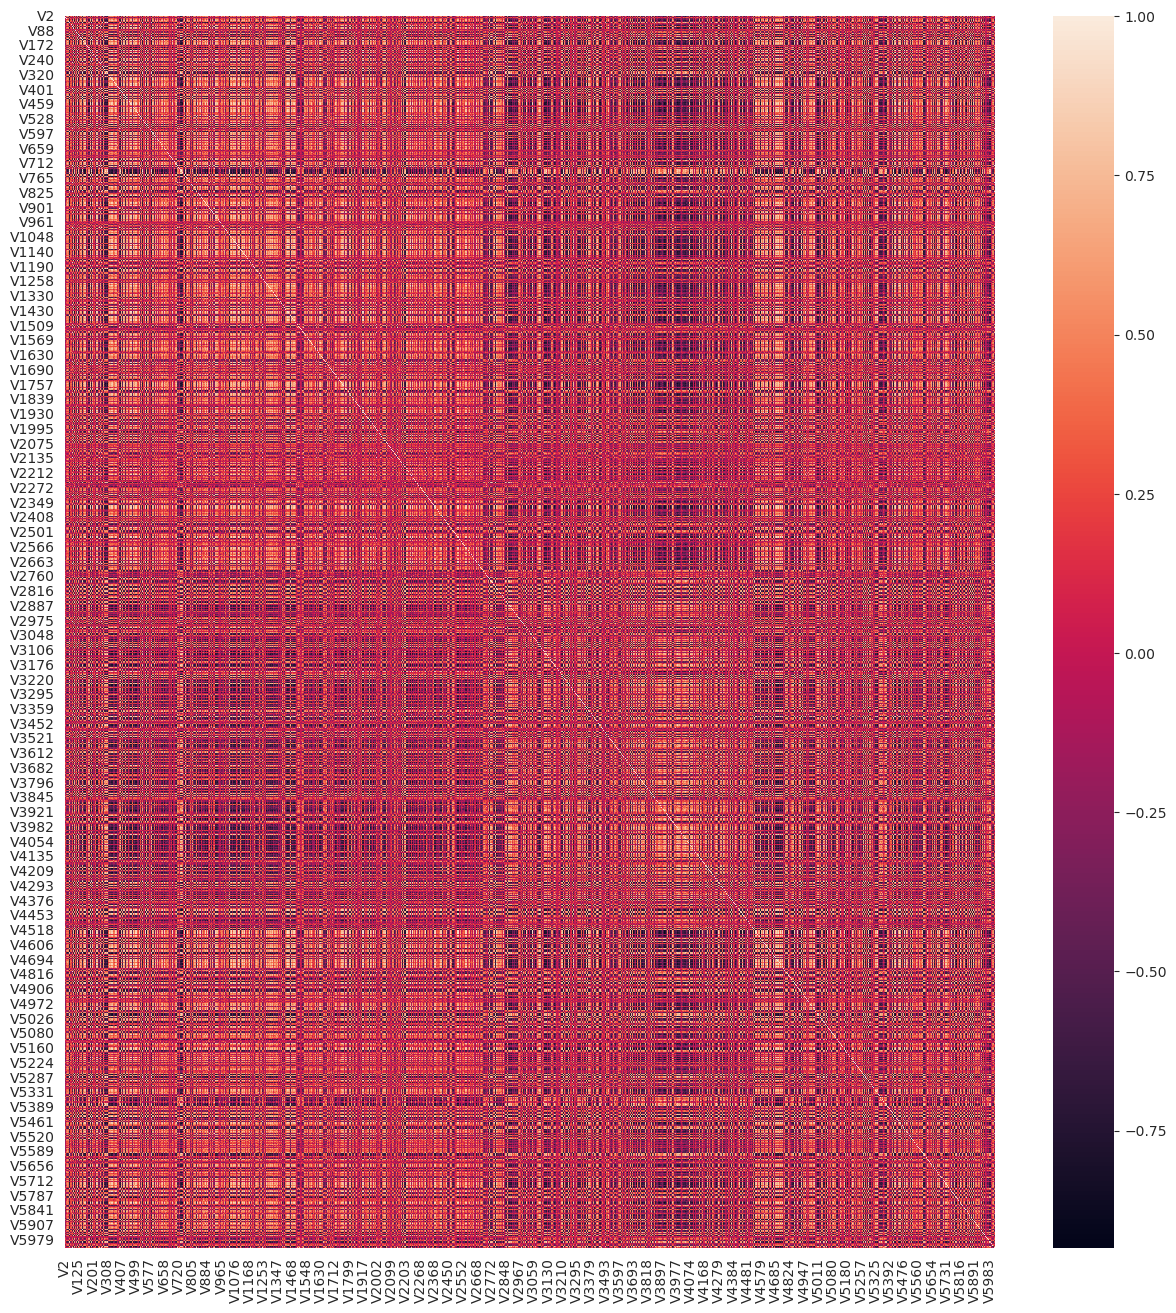

In [ ]:
cor = data[features].corr()
plt.figure(figsize=(15,16))
sns.heatmap(cor)

## Building and spliting new data

In [ ]:
print(len(features))
new_x = x[features]
new_x.head()

1504


V2        V3       V12       V24       V27       V33       V34  \
86 -0.882561 -0.062993 -0.420086  0.321612 -0.882561 -0.360432 -0.882561   
29 -0.849856 -0.135850 -0.849856  0.299120 -0.849856 -0.849856 -0.849856   
0  -0.740039 -0.532016 -1.097891  1.421553 -1.097891 -0.351254 -1.097891   
82 -0.080795 -0.684729 -0.212329  0.422389 -0.943168  0.139010 -0.763574   
73 -1.000187 -0.420718 -1.000187  0.986202 -1.000187 -0.096863 -1.000187   

         V37       V43       V51  ...     V5979     V5983     V5986     V5997  \
86  3.234002 -0.882561 -0.882561  ...  0.094781  3.928714  1.032180 -0.106733   
29  2.974596 -0.849856 -0.849856  ... -0.849856  2.742512  1.036449  0.484250   
0   2.552726 -1.097891 -1.097891  ... -1.097891  3.159267  0.536904 -0.238727   
82  3.455936 -0.943168 -0.943168  ...  0.071049  1.859185  0.560060  0.642195   
73  3.071717 -1.000187 -1.000187  ...  0.234848  2.946844  0.643919  0.289631   

       V6003     V6008     V6015     V6016     V6022     V6025  
86  0.481528 -0.882561 -0.420086 -0.106733 -0.152508 -0.882561  
29  0.299120 -0.849856 -0.526051  0.575972 -0.339204 -0.849856  
0  -1.097891 -1.097891  0.308128 -0.179231 -0.810672 -1.097891  
82  1.001383 -0.943168 -0.943168  0.202583 -0.943168 -0.943168  
73  0.146504 -1.000187 -0.741535 -0.137107 -1.000187 -1.000187  

[5 rows x 1504 columns]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(new_x, y, test_size = 0.3, random_state = 101)
print("x_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("x_text: ",X_test.shape)
print("y_test: ",y_test.shape)

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train = sc.fit_transform(X_train)
x_test = sc.transform(X_test)

x_train shape:  (71, 1504)
y_train shape:  (71,)
x_text:  (31, 1504)
y_test:  (31,)


## Classification

### SVC

[[13  1]
 [ 4 13]]


              precision    recall  f1-score   support

         0.0       0.76      0.93      0.84        14
         1.0       0.93      0.76      0.84        17

    accuracy                           0.84        31
   macro avg       0.85      0.85      0.84        31
weighted avg       0.85      0.84      0.84        31



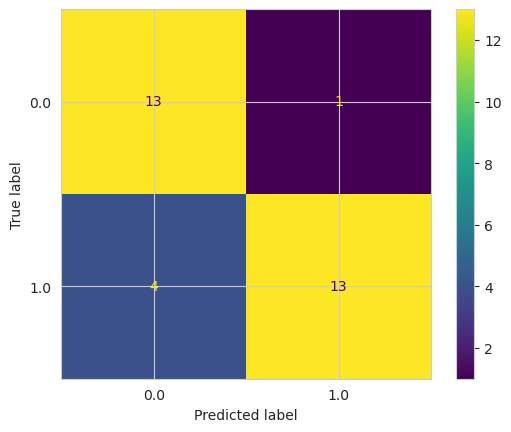

In [ ]:
model_SVC= SVC()
model_SVC.fit(x_train,y_train)
model_pred = model_SVC.predict(x_test)
cm = confusion_matrix(y_test,model_pred)
print(cm)
print('\n')

disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_SVC.classes_)
disp.plot()
print(classification_report(y_test,model_pred))


In [ ]:
# Calculate all
precision,recall,f1_score = evaluate_fn(y_test, model_pred)  # takes y_test and model pred
print("precision : ",precision,'\n',"recall :",recall,'\n',"f1_score :",f1_score)

# K-Fold
acc = k_evaluate(10, model_SVC, new_x, y)

precision :  0.9285714285714286 
 recall : 0.7647058823529411 
 f1_score : 0.8387096774193549
for fold: 2, accuracy is: 0.5980392156862745
for fold: 3, accuracy is: 0.7745098039215685
for fold: 4, accuracy is: 0.833076923076923
for fold: 5, accuracy is: 0.8428571428571429
for fold: 6, accuracy is: 0.8529411764705882
for fold: 7, accuracy is: 0.873469387755102
for fold: 8, accuracy is: 0.8725961538461539
for fold: 9, accuracy is: 0.8636363636363638
for fold: 10, accuracy is: 0.8727272727272728
Best fit
7 gives accuracy of 0.873469387755102


### Naive Bayes

[[ 9  5]
 [ 6 11]]


              precision    recall  f1-score   support

         0.0       0.60      0.64      0.62        14
         1.0       0.69      0.65      0.67        17

    accuracy                           0.65        31
   macro avg       0.64      0.64      0.64        31
weighted avg       0.65      0.65      0.65        31



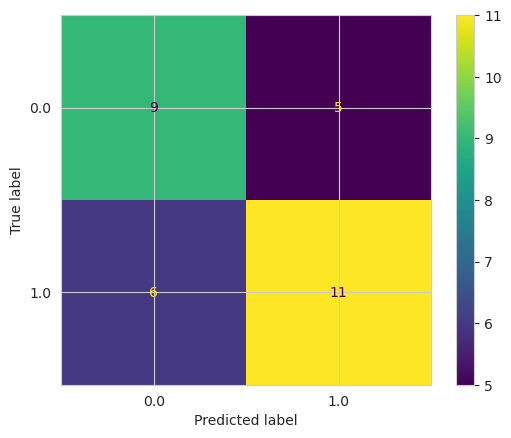

In [ ]:
gnb = GaussianNB()
gnb.fit(x_train, y_train)

y_pred = gnb.predict(x_test)
cm = confusion_matrix(y_test,y_pred)
print(cm)
print('\n')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=gnb.classes_)
disp.plot()
print(classification_report(y_test,y_pred))

In [ ]:
# Calculate all
precision,recall,f1_score = evaluate_fn(y_test, y_pred)  # takes y_test and model pred
print("precision : ",precision,'\n',"recall :",recall,'\n',"f1_score :",f1_score)

# K-Fold
acc = k_evaluate(10, gnb, new_x, y)

precision :  0.6428571428571429 
 recall : 0.6 
 f1_score : 0.6206896551724138
for fold: 2, accuracy is: 0.5588235294117647
for fold: 3, accuracy is: 0.5882352941176471
for fold: 4, accuracy is: 0.5784615384615385
for fold: 5, accuracy is: 0.6090476190476191
for fold: 6, accuracy is: 0.6078431372549019
for fold: 7, accuracy is: 0.6190476190476192
for fold: 8, accuracy is: 0.5993589743589743
for fold: 9, accuracy is: 0.611952861952862
for fold: 10, accuracy is: 0.6109090909090908
Best fit
7 gives accuracy of 0.6190476190476192


### LDA

[[13  1]
 [ 4 13]]


              precision    recall  f1-score   support

         0.0       0.76      0.93      0.84        14
         1.0       0.93      0.76      0.84        17

    accuracy                           0.84        31
   macro avg       0.85      0.85      0.84        31
weighted avg       0.85      0.84      0.84        31

              precision    recall  f1-score   support

         0.0       0.76      0.93      0.84        14
         1.0       0.93      0.76      0.84        17

    accuracy                           0.84        31
   macro avg       0.85      0.85      0.84        31
weighted avg       0.85      0.84      0.84        31

precision :  0.9285714285714286 
 recall : 0.7647058823529411 
 f1_score : 0.8387096774193549




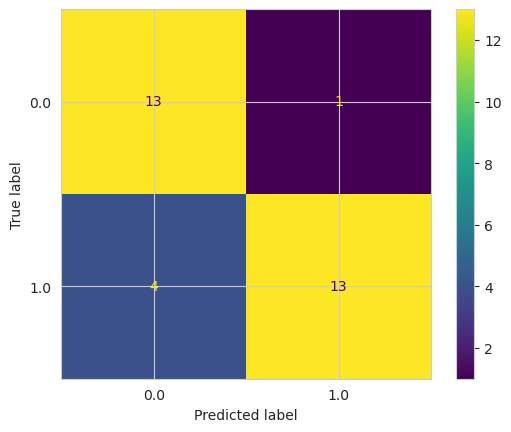

In [ ]:

lda = LinearDiscriminantAnalysis()
lda.fit(x_train,y_train)
lda_pred = lda.predict(x_test)
cm = confusion_matrix(y_test,lda_pred)
print(cm)
print('\n')
print(classification_report(y_test,lda_pred))

disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=lda.classes_)
disp.plot()
print(classification_report(y_test,lda_pred))

# Calculate all
precision,recall,f1_score = evaluate_fn(y_test, lda_pred)  # takes y_test and model pred
print("precision : ",precision,'\n',"recall :",recall,'\n',"f1_score :",f1_score)
print('\n')

In [ ]:
# K-FOLD Cross Validation
acc = k_evaluate(10, lda, new_x, y)  # here k 10

for fold: 2, accuracy is: 0.7745098039215687
for fold: 3, accuracy is: 0.8333333333333334
for fold: 4, accuracy is: 0.8611538461538462
for fold: 5, accuracy is: 0.8514285714285714
for fold: 6, accuracy is: 0.8333333333333334
for fold: 7, accuracy is: 0.8605442176870748
for fold: 8, accuracy is: 0.8621794871794872
for fold: 9, accuracy is: 0.8602693602693603
for fold: 10, accuracy is: 0.840909090909091
Best fit
8 gives accuracy of 0.8621794871794872


### Decision Tree

[[13  1]
 [ 3 14]]


              precision    recall  f1-score   support

         0.0       0.81      0.93      0.87        14
         1.0       0.93      0.82      0.87        17

    accuracy                           0.87        31
   macro avg       0.87      0.88      0.87        31
weighted avg       0.88      0.87      0.87        31



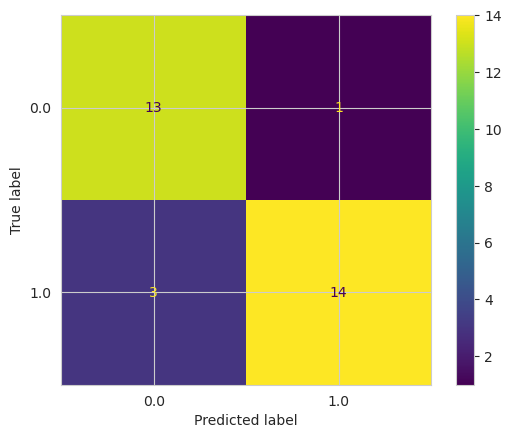

In [ ]:
dt = DecisionTreeClassifier()
dt.fit(x_train, y_train)
dt_pred = dt.predict(x_test)
cm = confusion_matrix(y_test,dt_pred)
print(cm)
print('\n')
print(classification_report(y_test,dt_pred))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=dt.classes_)
disp.plot()

In [ ]:
# Calculate all
precision,recall,f1_score = evaluate_fn(y_test, dt_pred)  # takes y_test and model pred
print("precision : ",precision,'\n',"recall :",recall,'\n',"f1_score :",f1_score)
print("\n")
# K-Fold
acc = k_evaluate(10, dt, new_x, y)


precision :  0.9285714285714286 
 recall : 0.8125 
 f1_score : 0.8666666666666666


for fold: 2, accuracy is: 0.8235294117647058
for fold: 3, accuracy is: 0.7549019607843137
for fold: 4, accuracy is: 0.8142307692307692
for fold: 5, accuracy is: 0.7938095238095239
for fold: 6, accuracy is: 0.784313725490196
for fold: 7, accuracy is: 0.7537414965986395
for fold: 8, accuracy is: 0.7139423076923077
for fold: 9, accuracy is: 0.7457912457912458
for fold: 10, accuracy is: 0.7736363636363637
Best fit
2 gives accuracy of 0.8235294117647058


### Random Forest

[[14  0]
 [ 5 12]]


              precision    recall  f1-score   support

         0.0       0.74      1.00      0.85        14
         1.0       1.00      0.71      0.83        17

    accuracy                           0.84        31
   macro avg       0.87      0.85      0.84        31
weighted avg       0.88      0.84      0.84        31



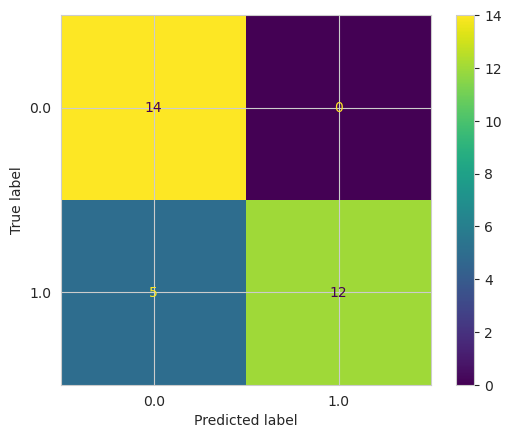

In [ ]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(x_train, y_train)
y_pred = rf_classifier.predict(x_test)


cm = confusion_matrix(y_test,y_pred)
print(cm)
print('\n')
print(classification_report(y_test,y_pred))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=rf_classifier.classes_)
disp.plot()

In [ ]:
# Calculate all
precision,recall,f1_score = evaluate_fn(y_test, y_pred)  # takes y_test and model pred
print("precision : ",precision,'\n',"recall :",recall,'\n',"f1_score :",f1_score)
print("\n")
# K-Fold
acc = k_evaluate(10, rf_classifier, new_x, y)

precision :  1.0 
 recall : 0.7368421052631579 
 f1_score : 0.8484848484848484


for fold: 2, accuracy is: 0.7254901960784315
for fold: 3, accuracy is: 0.8333333333333334
for fold: 4, accuracy is: 0.8526923076923076
for fold: 5, accuracy is: 0.8623809523809524
for fold: 6, accuracy is: 0.8725490196078431
for fold: 7, accuracy is: 0.8523809523809522
for fold: 8, accuracy is: 0.8421474358974359
for fold: 9, accuracy is: 0.8821548821548822
for fold: 10, accuracy is: 0.8627272727272729
Best fit
9 gives accuracy of 0.8821548821548822


# Differential Evolution (DE)

DE is an optimization technique that involves creating new candidate solutions by combining information from existing solutions. In the context of feature selection, DE can be used to generate new feature subsets by combining features from different subsets.

## Implementation

In [ ]:
# please ensure that both X and y have same number of samples i.e 102 if notrerun the "Data Reading & Visualization part"
print(X.shape)
print(y.shape)

(102, 6033)
(102,)


In [ ]:
def init_position(lb, ub, N, dim):
    X = np.zeros([N, dim], dtype='float')
    for i in range(N):
        for d in range(dim):
            X[i,d] = lb[0,d] + (ub[0,d] - lb[0,d]) * rand()

    return X

def binary_conversion(X, thres, N, dim):
    Xbin = np.zeros([N, dim], dtype='int')
    for i in range(N):
        for d in range(dim):
            if X[i,d] > thres:
                Xbin[i,d] = 1
            else:
                Xbin[i,d] = 0

    return Xbin

def boundary(x, lb, ub):
    if x < lb:
        x = lb
    if x > ub:
        x = ub

    return x

In [ ]:
def differentialEvolution(xtrain, ytrain, opts):
    # Parameters
    ub    = 1
    lb    = 0
    thres = 0.5
    CR    = 0.9     # crossover rate
    F     = 0.5     # factor

    N        = opts['N']
    max_iter = opts['T']
    if 'CR' in opts:
        CR   = opts['CR']
    if 'F' in opts:
        F    = opts['F']

    # Dimension
    dim = np.size(xtrain, 1)
    if np.size(lb) == 1:
        ub = ub * np.ones([1, dim], dtype='float')
        lb = lb * np.ones([1, dim], dtype='float')

    # Initialize position
    X     = init_position(lb, ub, N, dim)

    # Binary conversion
    Xbin  = binary_conversion(X, thres, N, dim)

    # Fitness at first iteration
    fit   = np.zeros([N, 1], dtype='float')
    Xgb   = np.zeros([1, dim], dtype='float')
    fitG  = float('inf')

    for i in range(N):
        fit[i,0] = Fun(xtrain, ytrain, Xbin[i,:], opts)
        if fit[i,0] < fitG:
            Xgb[0,:] = X[i,:]
            fitG     = fit[i,0]

    # Pre
    curve = np.zeros([1, max_iter], dtype='float')
    t     = 0

    curve[0,t] = fitG.copy()
    print("Generation:", t + 1)
    print("Best (DE):", curve[0,t])
    t += 1

    while t < max_iter:
        V = np.zeros([N, dim], dtype='float')
        U = np.zeros([N, dim], dtype='float')

        for i in range(N):
            # Choose r1, r2, r3 randomly, but not equal to i
            RN = np.random.permutation(N)
            for j in range(N):
                if RN[j] == i:
                    RN = np.delete(RN, j)
                    break

            r1 = RN[0]
            r2 = RN[1]
            r3 = RN[2]
            # mutation (2)
            for d in range(dim):
                V[i,d] = X[r1,d] + F * (X[r2,d] - X[r3,d])
                # Boundary
                V[i,d] = boundary(V[i,d], lb[0,d], ub[0,d])

            # Random one dimension from 1 to dim
            index = np.random.randint(low = 0, high = dim)
            # crossover (3-4)
            for d in range(dim):
                if (rand() <= CR)  or  (d == index):
                    U[i,d] = V[i,d]
                else:
                    U[i,d] = X[i,d]

        # Binary conversion
        Ubin = binary_conversion(U, thres, N, dim)

        # Selection
        for i in range(N):
            fitU = Fun(xtrain, ytrain, Ubin[i,:], opts)
            if fitU <= fit[i,0]:
                X[i,:]   = U[i,:]
                fit[i,0] = fitU

            if fit[i,0] < fitG:
                Xgb[0,:] = X[i,:]
                fitG     = fit[i,0]


        # Store result
        curve[0,t] = fitG.copy()
        print("Generation:", t + 1)
        print("Best (DE):", curve[0,t])
        t += 1


    # Best feature subset
    Gbin       = binary_conversion(Xgb, thres, 1, dim)
    Gbin       = Gbin.reshape(dim)
    pos        = np.asarray(range(0, dim))
    sel_index  = pos[Gbin == 1]
    num_feat   = len(sel_index)
    # Create dictionary
    de_data = {'sf': sel_index, 'c': curve, 'nf': num_feat}

    return de_data


In [ ]:
# from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y.values, test_size = 0.3, random_state = 101)
print("x_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("x_text: ",X_test.shape)
print("y_test: ",y_test.shape)

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# parameter
k    = 5     # k-value in KNN
N    = 10   # number of chromosomes
T    = 100   # maximum number of iterations
CR   = 0.9  # crossover rate
F = 0.5 # constant factor
fold = {'xt':X_train, 'yt':y_train, 'xv':X_test, 'yv':y_test}
X = x.to_numpy()
Y = y.values
opts = {'k':k, 'fold':fold, 'N':N, 'T':T, 'CR':CR, 'F':F}

x_train shape:  (71, 6033)
y_train shape:  (71,)
x_text:  (31, 6033)
y_test:  (31,)


In [ ]:
print(type(X))
print(type(Y))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [ ]:
result = differentialEvolution(X, Y, opts)
sel_feat   = result['sf']

Generation: 1
Best (DE): 0.164603658373569
Generation: 2
Best (DE): 0.13275768221020945
Generation: 3
Best (DE): 0.10077744448543764
Generation: 4
Best (DE): 0.10077744448543764
Generation: 5
Best (DE): 0.10077744448543764
Generation: 6
Best (DE): 0.10077744448543764
Generation: 7
Best (DE): 0.10077744448543764
Generation: 8
Best (DE): 0.10077744448543764
Generation: 9
Best (DE): 0.10075921143388783
Generation: 10
Best (DE): 0.10070948492966109
Generation: 11
Best (DE): 0.10070948492966109
Generation: 12
Best (DE): 0.10070948492966109
Generation: 13
Best (DE): 0.10066638862599789
Generation: 14
Best (DE): 0.10066638862599789
Generation: 15
Best (DE): 0.10066638862599789
Generation: 16
Best (DE): 0.10066638862599789
Generation: 17
Best (DE): 0.10066638862599789
Generation: 18
Best (DE): 0.10066638862599789
Generation: 19
Best (DE): 0.10066638862599789
Generation: 20
Best (DE): 0.10066638862599789
Generation: 21
Best (DE): 0.10066638862599789
Generation: 22
Best (DE): 0.10066638862599789

In [ ]:
f = result['sf']
# featching features
features = []
for key, val in col_dict.items():
  if key in f:
    features.append(col_dict.get(key))
print("Number of features found: ", len(features))

Number of features found:  2810


In [ ]:
new_x = x[features]
X_train, X_test, y_train, y_test = train_test_split(new_x, y.values, test_size = 0.3, random_state = 101)
print("x_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("x_text: ",X_test.shape)
print("y_test: ",y_test.shape)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

x_train shape:  (71, 2810)
y_train shape:  (71,)
x_text:  (31, 2810)
y_test:  (31,)


## Classification

### SVC

[[13  1]
 [ 4 13]]


              precision    recall  f1-score   support

         0.0       0.76      0.93      0.84        14
         1.0       0.93      0.76      0.84        17

    accuracy                           0.84        31
   macro avg       0.85      0.85      0.84        31
weighted avg       0.85      0.84      0.84        31



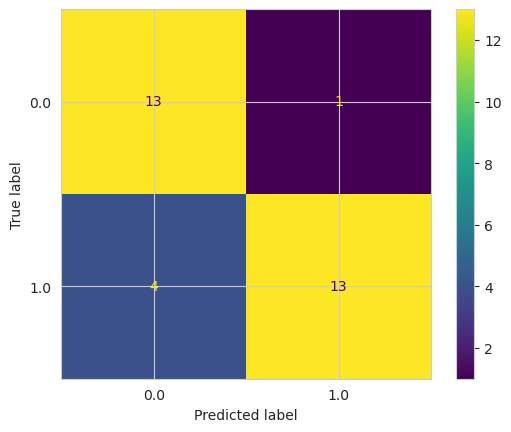

In [ ]:
model_SVC= SVC()
model_SVC.fit(X_train,y_train)
model_pred = model_SVC.predict(X_test)
cm = confusion_matrix(y_test,model_pred)
print(cm)
print('\n')

disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_SVC.classes_)
disp.plot()
print(classification_report(y_test,model_pred))


In [ ]:
# Calculate all
precision,recall,f1_score = evaluate_fn(y_test, model_pred)  # takes y_test and model pred
print("precision : ",precision,'\n',"recall :",recall,'\n',"f1_score :",f1_score)

# K-Fold
acc = k_evaluate(10, model_SVC, new_x, y)

precision :  0.9285714285714286 
 recall : 0.7647058823529411 
 f1_score : 0.8387096774193549
for fold: 2, accuracy is: 0.6666666666666667
for fold: 3, accuracy is: 0.7941176470588235
for fold: 4, accuracy is: 0.8234615384615385
for fold: 5, accuracy is: 0.8338095238095239
for fold: 6, accuracy is: 0.8529411764705882
for fold: 7, accuracy is: 0.8632653061224488
for fold: 8, accuracy is: 0.8629807692307693
for fold: 9, accuracy is: 0.8737373737373738
for fold: 10, accuracy is: 0.8627272727272729
Best fit
9 gives accuracy of 0.8737373737373738


### Naive Bayes

[[ 9  5]
 [ 6 11]]


              precision    recall  f1-score   support

         0.0       0.60      0.64      0.62        14
         1.0       0.69      0.65      0.67        17

    accuracy                           0.65        31
   macro avg       0.64      0.64      0.64        31
weighted avg       0.65      0.65      0.65        31



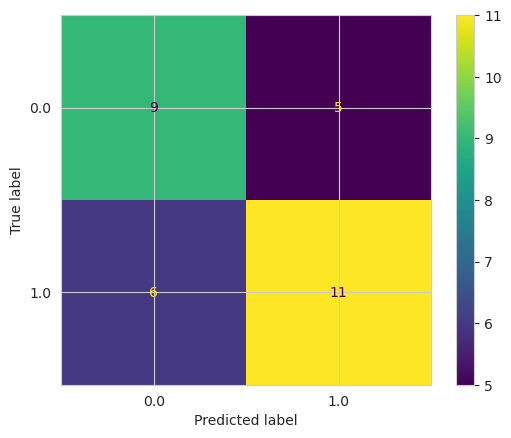

In [ ]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)

y_pred = gnb.predict(X_test)
cm = confusion_matrix(y_test,y_pred)
print(cm)
print('\n')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=gnb.classes_)
disp.plot()
print(classification_report(y_test,y_pred))

In [ ]:
# Calculate all
precision,recall,f1_score = evaluate_fn(y_test, y_pred)  # takes y_test and model pred
print("precision : ",precision,'\n',"recall :",recall,'\n',"f1_score :",f1_score)

# K-Fold
acc = k_evaluate(10, gnb, new_x, y)

precision :  0.6428571428571429 
 recall : 0.6 
 f1_score : 0.6206896551724138
for fold: 2, accuracy is: 0.5686274509803921
for fold: 3, accuracy is: 0.5784313725490197
for fold: 4, accuracy is: 0.5692307692307693
for fold: 5, accuracy is: 0.5995238095238095
for fold: 6, accuracy is: 0.6078431372549019
for fold: 7, accuracy is: 0.6095238095238095
for fold: 8, accuracy is: 0.608974358974359
for fold: 9, accuracy is: 0.611952861952862
for fold: 10, accuracy is: 0.6109090909090908
Best fit
9 gives accuracy of 0.611952861952862


### Decision Tree

[[12  2]
 [ 2 15]]


              precision    recall  f1-score   support

         0.0       0.86      0.86      0.86        14
         1.0       0.88      0.88      0.88        17

    accuracy                           0.87        31
   macro avg       0.87      0.87      0.87        31
weighted avg       0.87      0.87      0.87        31



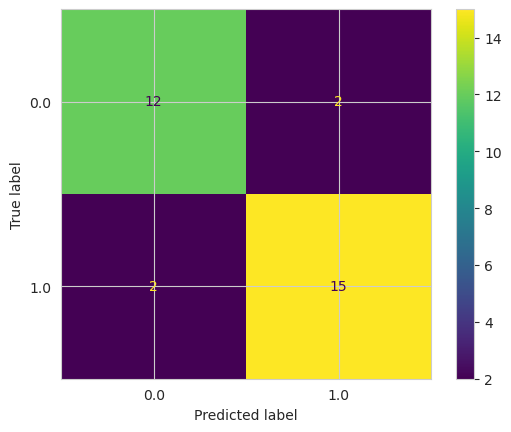

In [ ]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
dt_pred = dt.predict(X_test)
cm = confusion_matrix(y_test,dt_pred)
print(cm)
print('\n')
print(classification_report(y_test,dt_pred))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=dt.classes_)
disp.plot()

In [ ]:
# Calculate all
precision,recall,f1_score = evaluate_fn(y_test, dt_pred)  # takes y_test and model pred
print("precision : ",precision,'\n',"recall :",recall,'\n',"f1_score :",f1_score)
print("\n")
# K-Fold
acc = k_evaluate(10, dt, new_x, y)

precision :  0.8571428571428571 
 recall : 0.8571428571428571 
 f1_score : 0.8571428571428571


for fold: 2, accuracy is: 0.7843137254901961
for fold: 3, accuracy is: 0.8725490196078431
for fold: 4, accuracy is: 0.8723076923076922
for fold: 5, accuracy is: 0.8928571428571429
for fold: 6, accuracy is: 0.8627450980392156
for fold: 7, accuracy is: 0.8517006802721089
for fold: 8, accuracy is: 0.8629807692307692
for fold: 9, accuracy is: 0.872895622895623
for fold: 10, accuracy is: 0.8618181818181817
Best fit
5 gives accuracy of 0.8928571428571429


### LDA

[[14  0]
 [ 2 15]]


              precision    recall  f1-score   support

         0.0       0.88      1.00      0.93        14
         1.0       1.00      0.88      0.94        17

    accuracy                           0.94        31
   macro avg       0.94      0.94      0.94        31
weighted avg       0.94      0.94      0.94        31

              precision    recall  f1-score   support

         0.0       0.88      1.00      0.93        14
         1.0       1.00      0.88      0.94        17

    accuracy                           0.94        31
   macro avg       0.94      0.94      0.94        31
weighted avg       0.94      0.94      0.94        31

precision :  1.0 
 recall : 0.875 
 f1_score : 0.9333333333333333




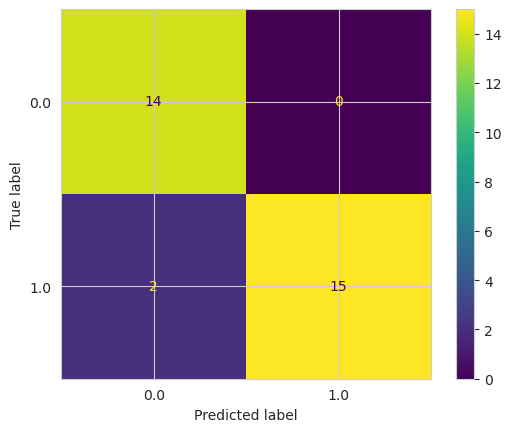

In [ ]:

lda = LinearDiscriminantAnalysis()
lda.fit(X_train,y_train)
lda_pred = lda.predict(X_test)
cm = confusion_matrix(y_test,lda_pred)
print(cm)
print('\n')
print(classification_report(y_test,lda_pred))

disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=lda.classes_)
disp.plot()
print(classification_report(y_test,lda_pred))

# Calculate all
precision,recall,f1_score = evaluate_fn(y_test, lda_pred)  # takes y_test and model pred
print("precision : ",precision,'\n',"recall :",recall,'\n',"f1_score :",f1_score)
print('\n')

In [ ]:
# K-FOLD Cross Validation
acc = k_evaluate(10, lda, new_x, y)  # here k 10

for fold: 2, accuracy is: 0.7647058823529411
for fold: 3, accuracy is: 0.8627450980392157
for fold: 4, accuracy is: 0.8919230769230769
for fold: 5, accuracy is: 0.8914285714285715
for fold: 6, accuracy is: 0.872549019607843
for fold: 7, accuracy is: 0.880952380952381
for fold: 8, accuracy is: 0.8725961538461539
for fold: 9, accuracy is: 0.8914141414141413
for fold: 10, accuracy is: 0.891818181818182
Best fit
4 gives accuracy of 0.8919230769230769


### Random Forest

[[14  0]
 [ 4 13]]


              precision    recall  f1-score   support

         0.0       0.78      1.00      0.88        14
         1.0       1.00      0.76      0.87        17

    accuracy                           0.87        31
   macro avg       0.89      0.88      0.87        31
weighted avg       0.90      0.87      0.87        31



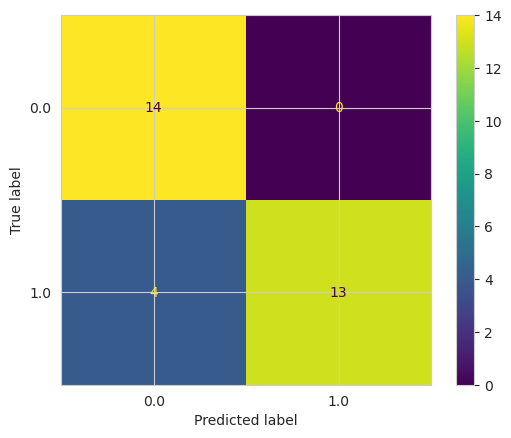

In [ ]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_test)


cm = confusion_matrix(y_test,y_pred)
print(cm)
print('\n')
print(classification_report(y_test,y_pred))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=rf_classifier.classes_)
disp.plot()

In [ ]:
# Calculate all
precision,recall,f1_score = evaluate_fn(y_test, y_pred)  # takes y_test and model pred
print("precision : ",precision,'\n',"recall :",recall,'\n',"f1_score :",f1_score)
print("\n")
# K-Fold
acc = k_evaluate(10, rf_classifier, new_x, y)

precision :  1.0 
 recall : 0.7777777777777778 
 f1_score : 0.8750000000000001


for fold: 2, accuracy is: 0.7352941176470589
for fold: 3, accuracy is: 0.8039215686274509
for fold: 4, accuracy is: 0.8719230769230769
for fold: 5, accuracy is: 0.8419047619047617
for fold: 6, accuracy is: 0.8921568627450981
for fold: 7, accuracy is: 0.8836734693877552
for fold: 8, accuracy is: 0.8637820512820513
for fold: 9, accuracy is: 0.8922558922558923
for fold: 10, accuracy is: 0.8618181818181819
Best fit
9 gives accuracy of 0.8922558922558923


# Comparison

See the Breast Cancer Report card.